<!--
# SQLITE Database
To explore the SQLITE database, you can download (https://sqlitebrowser.org/).  There is a portable executable.
-->

# Non-Linear Regression on Production Data
**David S. Fulford**  
*January, 2019*

[Non-linear regression](https://en.wikipedia.org/wiki/Nonlinear_regression "Wikipedia") is the minimization of a cost function applied over predictions of any arbitrary function and observed data values.

While it is possible to linearize many problems and then fit a linear model, often we'd like to simply fit a non-linear function as it is to the observed non-linear data. Sometimes it's not possible to linearize a function, or it is not tractable to do so. While there are many types of regression algorithms in the realm of machine learning, this post isn't going to discuss things like support vector regression, kernel regression, etc. Instead, I'll show some examples of fitting known functions to observed data. This is useful given that, as engineers, we often have a *known* model that we'd like to regress.

#### Import the libraries we'll be using
* [Numpy](http://www.numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Matplotlib](https://matplotlib.org/) is a simple and powerful library for plotting.
* [Pandas](https://pandas.pydata.org/) is a library to replicates the R dataframe construct for Python. It isn't necessary, but it does help maintain the relations of our variables and provide a useful data collation object so we are not constantly passing multiple arrays around.
* [Scipy](https://www.scipy.org/) is extends the utility of Numpy with more complex and rigorous implementations of scientific functions. It re-implements the entirety of Numpy, meaning scipy.exp() is the same as Numpy.exp(), etc. It also provides a lot of extension to the core Numpy libraries. For any math, it is recommend to use the Scipy implementation instead of the Numpy one.
* [Scikit-learn](https://scikit-learn.org) is a machine learning library. It contains a great deal of functionality to simplify data analysis. We'll utilize some of the pre-processing and cross validation functions to perform model selection and validation.

We'll also setup a seaborn style (white) for our plots, and store the color palette to an object for easy reference. Last, we setup the use of magics with matplotlib. Magics are the lines that begin with `%`, which are commands interpreted by the IPython shell rather than the Python kernel. We'll use this to create fixed plot output for printing rather than interactive plots!

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
import pandas as pd
import scipy as sc
import scipy.optimize

#Do not display warnings
import warnings
warnings.simplefilter('ignore')

#Inline magic and style
#Inline magic and style
%matplotlib inline
plt.style.use('seaborn-white')
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
np.set_printoptions(precision=4, suppress=True)

## Robust Non-linear optimization
We can regress a model, that is some function arbitrary $f(x) = y$, to any data set. To do so, we must ***choose our cost function***. As discussing for linear regression, the choice is endless and left to the creativity of the engineer or scientist. Commonly used is, of course, squared residuals, but it is almost always never the best choice &mdash; just the one that is well behaved and therefore most often studied and supported. Recently, the availability of machine learning libraries and packages provide us the means to stop using least squares!

Let's look at an example of fitting a [damped harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator "Wikipedia").

<table><tr><td><img src='https://upload.wikimedia.org/wikipedia/commons/d/d5/Animated-mass-spring-faster.gif'></td>
<td><img src='https://upload.wikimedia.org/wikipedia/commons/7/74/Simple_harmonic_motion_animation.gif'></td></tr></table>

First, we'll set up a function to generate our generate. We can call this function to return the true model as well as specify noise and outliers.

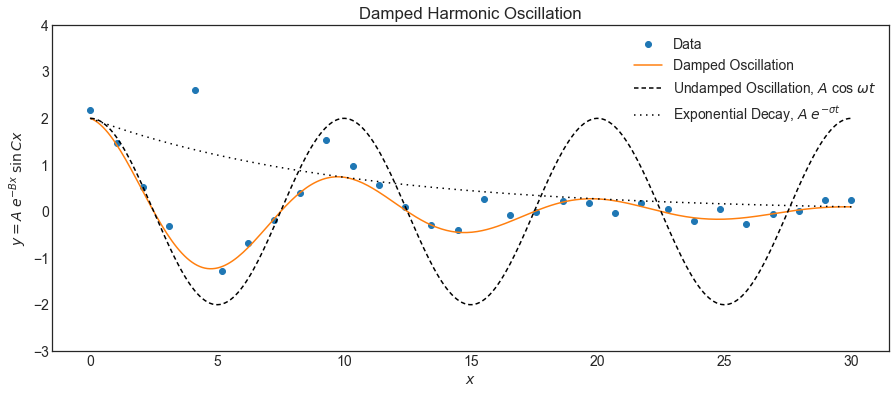

In [2]:
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.cos(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 20
    return y + error

A=2; sigma=0.1; omega=0.1 * 2 * np.pi
x_train = np.linspace(0, 30, 30)
y_train = generate_data(x_train, A, sigma, omega, noise=0.1, n_outliers=4)
y_train_no_err = generate_data(x_train, A, sigma, omega, noise=0.1, n_outliers=0)
x_test = np.linspace(0, 30, 300)
y_test = generate_data(x_test, A, sigma, omega)

plt.rcParams['font.size']=14
fig = plt.figure(figsize=(15,6))
plt.plot(x_train, y_train, 'o', label='Data')
plt.plot(x_test, y_test, label='Damped Oscillation')
plt.plot(x_test, A * np.cos(omega * x_test), label=r'Undamped Oscillation, $A$ cos $\omega t$', c='k', ls=(0,(3,2)))
plt.plot(x_test, A * np.exp(-sigma * x_test), label=r'Exponential Decay, $A$ $e^{-\sigma t}$', c='k', ls=(0,(1,3)))

# plt.hvline()

plt.gca().set(title='Damped Harmonic Oscillation', xlabel=r'$x$', ylabel=r'$y = A \; e^{-Bx} \;\sin{\,Cx}$', ylim=(-3,4))
plt.legend()

plt.show()

We see the undamped oscillation, and the exponential decay that is imposed on the oscillation to yield the damped oscillation. We also have our "data", which contains noise with 4 outliers, one of which is quite severe.

Let's fit the data. We'll use L2 on the true data, L2 on the noisy data, the Huber loss, and the Soft L1 which looks a lot like the Huber. The Soft L1 is useful because it is has an analytic representation of its gradient, and libraries are available which will optimize it so that we don't have to always write our own cost function.

Let's take a look at a comparison of these cost functions:

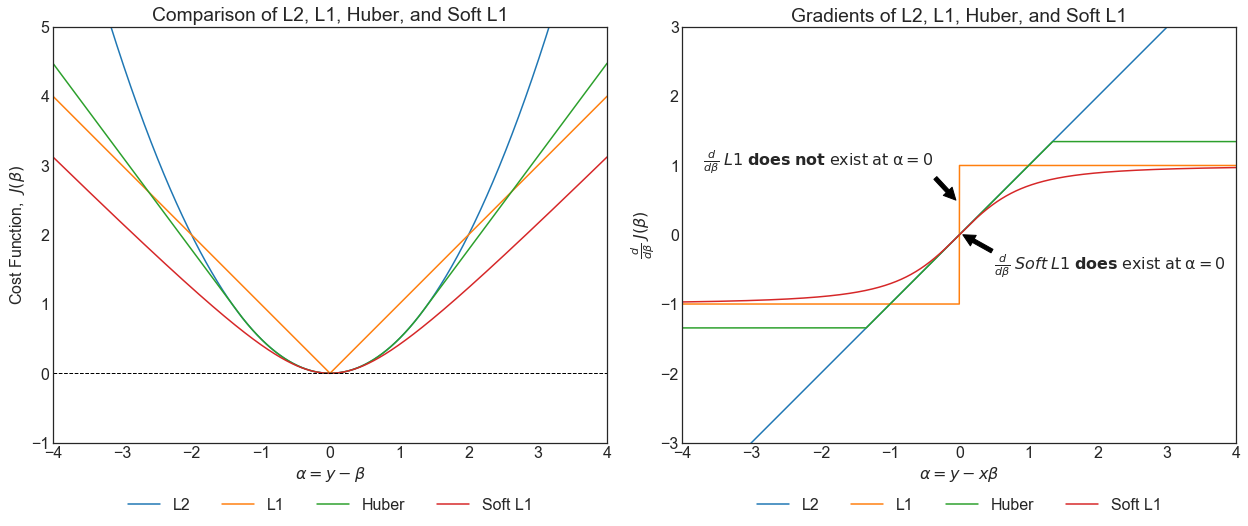

In [3]:
def huber_loss(x, t=1.345):
    # Definition from statsmodels.robust.norms.HuberT
    x = np.abs(x)
    subset = 1. * x<=1.345
    return (subset * 1/2 * x**2 + (1 - subset) * (x * t - 1/2 * t**2))

x = np.linspace(-5, 5, 10001)
l2_x = 1/2 * x**2
l1_x = np.abs(x)
soft_l1_x = (np.sqrt(1 + x**2) - np.sqrt(1))
huber_x = huber_loss(x)
y = np.stack([l2_x, l1_x, huber_x, soft_l1_x])
dy = np.asarray([np.gradient(f, x) for f in y])

mpl.rcParams['font.size'] = 16
plt.figure(figsize=(18,8))
plt.gcf().add_subplot(121)

plt.plot(x, y.T)
plt.axhline(0, c='k', ls='--', lw=1)

plt.xlim((-4,4)); plt.ylim((-1,5))
plt.xlabel(r'$\alpha = y - \beta$')
plt.ylabel(r'Cost Function,  $J(\beta)$')
plt.title('Comparison of L2, L1, Huber, and Soft L1')
labels = ['L2', 'L1', 'Huber', 'Soft L1']
plt.legend(labels=labels, bbox_to_anchor=(.5, -.15), loc=10, ncol=4)
plt.gca().set_aspect('equal')

plt.gcf().add_subplot(122)

plt.plot(x, dy.T)

plt.xlim(-4,4); plt.ylim(-3,3)
plt.xlabel(r'$\alpha = y - x\beta$')
plt.ylabel(r'$\frac {d}{d\beta}\; J(\beta) $')
plt.title('Gradients of L2, L1, Huber, and Soft L1')

plt.annotate(r'$ \frac{d}{d\beta} \; Soft\;  L1 \; \bf does \; \sf exist \; at \; \alpha = 0 $',
             xy=(.05, 0), xytext=(0.5, -.5), arrowprops=dict(facecolor='k'))
plt.annotate(r'$ \frac{d}{d\beta} \; L1 \; \bf does \; not \; \sf exist \; at \; \alpha = 0 $',
             xy=(-.05, .5), xytext=(-3.7, 1), arrowprops=dict(facecolor='k'))

labels = ['L2', 'L1', 'Huber', 'Soft L1']
plt.legend(labels=labels, bbox_to_anchor=(.5, -.15), loc=10, ncol=4)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

#### Set up cost functions
Let's define our cost functions. This isn't really necessary as we can just use the Soft L1, but the purpose of this is to illustrate and compare the differences, so onward we go!

In [4]:
def L2_opt(W, X, Y, pred_fun):
    e = Y - pred_fun(W, X)
    return np.sum(1/2 * e**2)

def L2_g_opt(W, X, Y, pred_fun):
    e = Y - pred_fun(W, X)    
    jac1 = np.sum(e * -np.exp(-W[1] * X) * np.cos(W[2] * X))
    jac2 = np.sum(e * -W[0] * np.exp(-W[1] * X) * np.cos(W[2] * X) * -X)
    jac3 = np.sum(e * -W[0] * np.exp(-W[1] * X) * -np.sin(W[2] * X) * X)
    return np.array([jac1, jac2, jac3])

def L1_opt(W, X, Y, pred_fun):
    e = Y - pred_fun(W, X)
    return np.abs(e)

def Huber_opt(W, X, Y, pred_fun):
    t=1.345
    e = Y - pred_fun(W, X)
    z = np.abs(e)
    huber = np.zeros_like(z)
    huber[z <= t] = 1/2 * z[z <= t]**2
    huber[z > t]  = t * z[z > t] - 1/2 * t**2
    return np.sum(huber)

#### Optimize
In the code below, we use both the `sc.optimize.minimize` function ***and*** the `sc.optimize.least_squares` function. The difference in these functions is that `minimize` takes the cost function we wish to minimize, while `least_squares` takes the residuals (i.e. first difference of model and data) and then applies the specified cost function itself.

- In the first L2 fit, I've specificed the Jacobian which is just the gradient with respect to every model parameter, i.e.:

$$
\textbf{J} = 
\begin{bmatrix}
\frac{\partial}{\partial A} \,      f(A,\sigma,\omega) &
\frac{\partial}{\partial \sigma} \, f(A,\sigma,\omega) &
\frac{\partial}{\partial \omega} \, f(A,\sigma,\omega)
\end{bmatrix}
$$

- The second function uses the same L2 cost and gradient to regress on the true data (no error).
- The third function uses the Huber cost function, but we haven't specified the Jacobian. Instead, the function will approximate it using a numerical method.
- The last function is `sc.optimize.least_squares`, which is nearly the same as the minimize function except that the function we provide is the function we wish to minimize, i.e. the calculation of the residuals. The cost function is split from the residual function and is specified by the `loss='soft_l1'` parameter. Of note is the `f_scale=.35` parameter, which is a scalar applied to the loss function which can adjust its sensitivity to outliers. A value of $1.39$ will make it approximately equal to the Huber loss. Here we've set it to be de-weight outliers even more.

Note that the `*reg_L2.x`, etc. uses an asterisk to unpack a tuple of the model parameters.

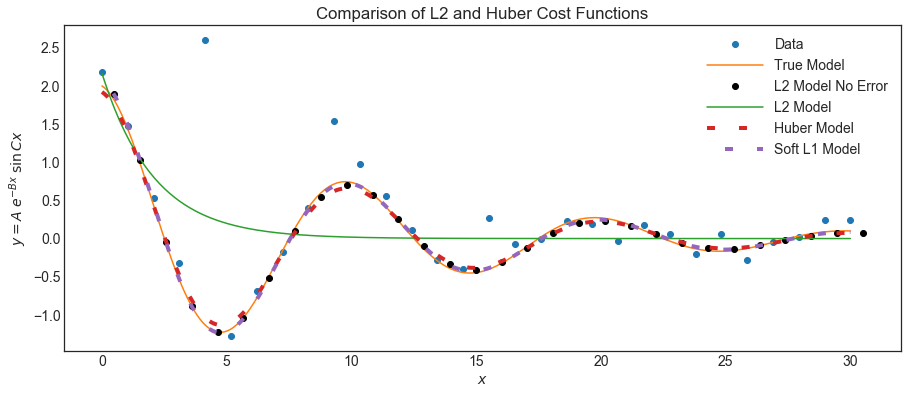

In [5]:
def pred_sin(W, X):
    return W[0] * np.exp(-W[1] * X) * np.cos(W[2] * X)

reg_L2 = sc.optimize.minimize(fun=L2_opt, jac=L2_g_opt, x0=np.ones(3), args=(x_train, y_train, pred_sin))
reg_L2_no_err = sc.optimize.minimize(fun=L2_opt, jac=L2_g_opt, x0=np.ones(3), args=(x_train, y_train_no_err, pred_sin))
# reg_L1 = sc.optimize.minimize(fun=L1_opt, x0=np.ones(3), args=(x_train, y_train, pred_sin))
reg_H = sc.optimize.minimize(fun=Huber_opt, x0=np.ones(3), args=(x_train, y_train, pred_sin))

reg_robust = sc.optimize.least_squares(fun=lambda W,X,Y: Y-pred_sin(W,X), x0=np.ones(3), args=(x_train, y_train),
                                       loss='soft_l1', f_scale=.35)

y_L2 = generate_data(x_test, *reg_L2.x)
y_L2_no_err = generate_data(x_train+.5, *reg_L2_no_err.x)
y_H = generate_data(x_test, *reg_H.x)
y_ls_H = generate_data(x_test, *reg_robust.x)

plt.rcParams['font.size']=14
fig = plt.figure(figsize=(15,6))
plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)
plt.plot(x_train+.5, y_L2_no_err, 'o', c='k')
plt.plot(x_test,y_L2)
plt.plot(x_test, y_H, ls=(0,(2,6)), lw=4)
plt.plot(x_test, y_ls_H, ls=(3.5,(2,6)), lw=4)

plt.gca().set(title='Comparison of L2 and Huber Cost Functions', xlabel=r'$x$', ylabel=r'$y = A \; e^{-Bx} \;\sin{\,Cx}$')
plt.legend(labels=['Data', 'True Model', 'L2 Model No Error', 'L2 Model', 'Huber Model', 'Soft L1 Model'], handlelength=4)

plt.show()

Just as we saw in the case of simple linear regression, the L2 cost function works well when every assumption is met, but breaks down quite horribly when any kid of outlier presents itself. In this example, it is nowhere near the correct parameters.

All of the other functions perform well. The difference in Huber and Soft L1 is the `f_scale` parameter which can be adjusted to increase or decrease the weighting of outliers. For the rest of this notebook, we'll use the Soft L1 for convenience. Again, these are effectively equivalent, so we'll just refer to either as the "Huber" cost function.

### Set up Sympy
We'll pull in Sympy and set up a decline curve model, as shown in the Rigline Convolution notebook.

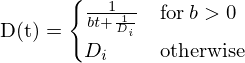

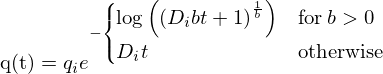

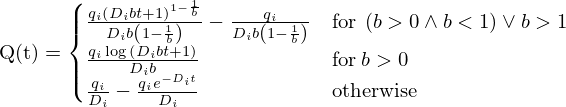

In [6]:
import sympy as sym

#Default Settings
sym.init_printing(use_unicode=True, wrap_line=False)

# Set up the symbols we will use and assumptions we can make about their values.
# As engineers, we only care about non-imaginary values!
Q = sym.Symbol('Q', real=True, nonnegative=True)
q = sym.Symbol('q', real=True, positive=True)
qi = sym.Symbol('q_i', real=True, positive=True)
D = sym.Symbol('D', real=True, positive=True)
Di = sym.Symbol('D_i', real=True, positive=True)
b = sym.Symbol('b', real=True, nonnegative=True)
t = sym.Symbol('t', real=True, nonnegative=True)
c = sym.Symbol('c', real=True)

# Derive the D(t) function. Sympy is not great at identifying singularities,
# so we help it along by defining a piecewise function at b=0.
arpsD = (1 / (sym.integrate(b, (t, 0, t)) + c)).subs([(c, 1/Di)])
arpsD = sym.Piecewise((arpsD, b>0), (arpsD.subs([(b, 0)]), True) )

# Derive the q(t) function. Logcombine simplifies our solution to force
# reduction of exp(ln(x)) to x.
arpsq = sym.integrate(arpsD, (t, 0, t))
arpsq = sym.logcombine(sym.exp(sym.log(qi) -1*(arpsq)), force=True)

# Sympy saves us a lot of effort here! Our piecewise function grows to include
# a special case when b=1.
arpscum = sym.integrate(arpsq, (t, 0, t))

#Represent these as functions for display
D_eq = sym.Eq(sym.Function('D(t)'), arpsD)
q_eq = sym.Eq(sym.Function('q(t)'), arpsq)
Q_eq = sym.Eq(sym.Function('Q(t)'), arpscum)
display(D_eq, q_eq, Q_eq)

### Well Data
Add our well data. This is an Eagle Ford well used in the **FATHYM_W** notebook.

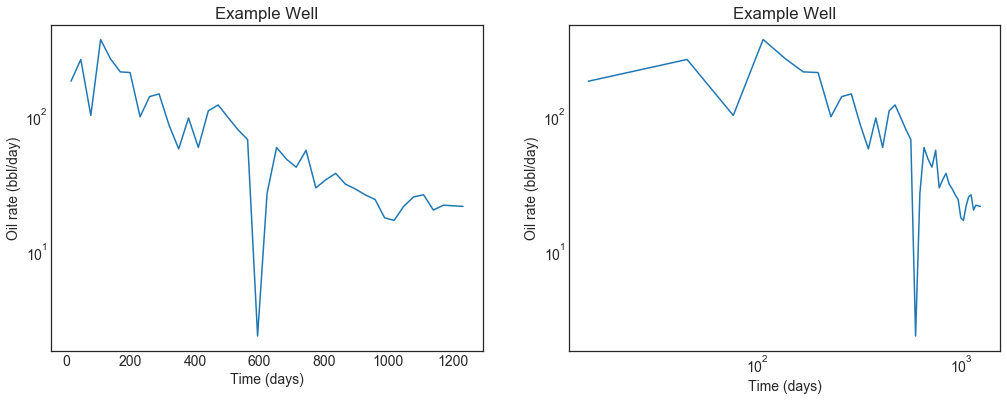

In [7]:
time = np.array([
    15.0, 45.5, 76.5, 107.0, 137.5, 168.0, 198.5, 229.5, 259.0, 288.5, 319.0,
    349.5, 380.0, 410.5, 441.5, 472.0, 502.5, 533.0, 563.5, 594.5, 624.0, 653.5,
    684.0, 714.5, 745.0, 775.5, 806.5, 837.0, 867.5, 898.0, 928.5, 959.5, 989.0,
    1018.5, 1049.0, 1079.5, 1110.0, 1140.5, 1171.5, 1202.0, 1232.5]
    , dtype='float')

rate = np.array([
    180.6333333, 261.6451613, 100.8387097, 367.5666667, 264.6774194, 211.8333333,
    209.3548387, 98.64516129, 139.0, 145.5483871, 86.2, 57.03225806, 96.6,
    58.48387097, 109.0322581, 120.5666667, 97.5483871, 79.36666667, 66.87096774,
    2.35483871, 26.75, 58.41935484, 47.9, 41.77419355, 55.73333333, 29.38709677,
    33.74193548, 37.6, 31.25806452, 28.83333333, 26.09677419, 24.09677419,
    17.64285714, 16.87096774, 21.53333333, 25.19354839, 26.1, 20.12903226,
    21.87096774, 21.63333333, 21.41935484]
    , dtype='float')

fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.semilogy(time, rate)
plt.xlabel('Time (days)')
plt.ylabel('Oil rate (bbl/day)')
plt.title('Example Well')

ax1 = fig.add_subplot(122)
plt.loglog(time, rate)
plt.xlabel('Time (days)')
plt.ylabel('Oil rate (bbl/day)')
plt.title('Example Well')

plt.show()

Filter out the build-up period.

In [8]:
fit_time = time[3:]
fit_rate = rate[3:]
filtered_time = time[:3]
filtered_rate = rate[:3]

### Define Forecast Functions
Set up functions to compute an array of rate and cum production values using the Sympy equations.

In [9]:
# Define the function to apply to our time array
def forecast(time, args):
    qi = args[0]; Di = args[1]; b = args[2]
    if b > 1e-6:
        q = qi / (1 + Di * b * time) ** (1 / b)
    else:
        q = qi / np.exp(Di * time)
    q = np.array(q, dtype='float')
    return q

def forecastQ(time, args):
    args = np.round(args, 10)
    Q = [arpscum.subs([(qi, args[0]), (Di, args[1]), (b, args[2]), (t, time)]) for time in time]
    Q = np.array(Q, dtype='float')
    return Q

### Optimize
We need to set some initial guesses for our model parameters. In the harmonic oscillation example we simply used an array of ones, but here we can save a lot of time by being smarter. This doesn't have to be exact, just generally in the range.

We also need to set boundaries on our parameters, as our Sympy derivation does not allow negative values of initial decline or b-parameter! We also bound the initial rate to a reasonable range.

Again, the lambda function receives `parms`, which has the initial guess defined in the `x0=parm_init` parameter. We've defined our function to take an array/list/tuple and substitute into our Sympy equation. `args` provides additional arguments to our lambda function, i.e. time & rate. The lambda function simply returns the residuals, and the `loss` parameter sets Soft L1 as our cost function!

In [10]:
parm_init = np.asarray([200, .001, 1.])
L2_dca = sc.optimize.least_squares(fun=lambda parms, time, rate: rate - forecast(time, parms),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time, fit_rate),
                                   loss='linear')
Huber_dca = sc.optimize.least_squares(fun=lambda parms, time, rate: rate - forecast(time, parms),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time, fit_rate),
                                   loss='soft_l1', f_scale=.35)

Define an array of time against which to evaluate our fits.

In [11]:
forecast_time = np.linspace(15, 10000, 1001)
y_L2_dca = forecast(forecast_time, L2_dca.x)
y_Huber_dca = forecast(forecast_time, Huber_dca.x)

# cum_adj = lambda parms: np.sum(rate*365.25/12)/forecastQ([time[-1]], parms)/1000
# cum_L2_dca = forecastQ(forecast_time, L2_dca.x) * cum_adj(L2_dca.x)
# cum_Huber_dca = forecastQ(forecast_time, Huber_dca.x) * cum_adj(Huber_dca.x)

### Fit Parameters
Let's take a look at the fit parameters. We'll define a function to convert nominal decline to secant effective.

In [12]:
def secant_dec(parms):
    p = np.copy(parms)
    p[1] = (1 - (1 + p[2] * p[1] * 365.25) ** (-1 / p[2]))*100
    return np.round(p,3)

pd.DataFrame([secant_dec(L2_dca.x), secant_dec(Huber_dca.x)], columns=[r'$q_i$', r'$D_{eff}$', r'$b$'], index=['L2','Huber'])

$q_i$  $D_{eff}$    $b$
L2     10000.000     99.097  0.859
Huber    376.985     69.369  0.153

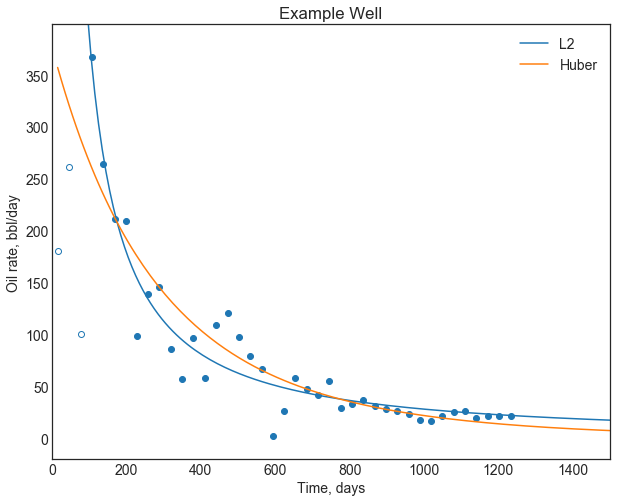

In [13]:
fig = plt.figure(figsize=(10,8))

plt.scatter(fit_time, fit_rate)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
plt.plot(forecast_time, y_L2_dca, label='L2')
plt.plot(forecast_time, y_Huber_dca, label='Huber')
plt.ylim(-20, 399)
plt.ylabel('Oil rate, bbl/day')
plt.legend()

# plt.gca().twinx()
# plt.scatter(time, np.cumsum(rate*365.25/12)/1000, marker='s', facecolor='white', edgecolor=colors[0])
# plt.plot(forecast_time, cum_L2_dca, ls=(0,(2,2)), label='L2 Cum')
# plt.plot(forecast_time, cum_Huber_dca, ls=(0,(2,2)), label='Huber Cum')
# plt.ylim(0,None)
# plt.ylabel('Oil Volume, Mbbl')

plt.xlim(0,1500)
plt.xlabel('Time, days')
plt.title('Example Well')
plt.show()

Well, that doesn't ***look*** too different... but the initial rates sure are, with 10,000 BPD for the L2 and 377 for the Huber.

We'll compute the point-by-point cost, which highlights the sensitivity of the cost function to each time-rate pair.

In [14]:
def L2cost(parms, time, rate):
    Yhat = forecast(time, parms)
    return 1/2 * np.sum(  (rate - Yhat)**2  )

def Hcost(parms, time, rate):
    Yhat = forecast(time, parms)
    return np.sum(  (np.sqrt(1 + (rate - Yhat)**2) - 1)  )

In [15]:
def single_L2cost(parms, time, rate, idx):
    Yhat = forecast(np.array([time[idx]]), parms)
    return 1/2 * np.sum(  (rate[idx] - Yhat)**2  )

def single_Hcost(parms, time, rate, idx):
    Yhat = forecast(np.array([time[idx]]), parms)
    return np.sum(  (np.sqrt(1 + (rate[idx] - Yhat)**2) - 1)  )

L2_cost = [single_L2cost(L2_dca.x, fit_time, fit_rate, idx) for idx in range(len(fit_time))]
Huber_cost = [single_Hcost(Huber_dca.x, fit_time, fit_rate, idx) for idx in range(len(fit_time))]

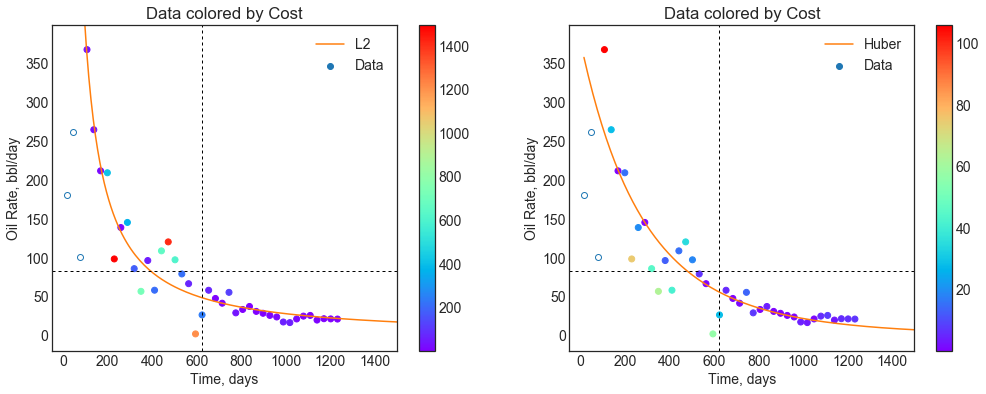

In [16]:
time0 = np.hstack((np.ones(len(fit_time))[:,None],fit_time[:,None]))
H = time0 @ sc.linalg.inv(time0.T @ time0) @ time0.T
H_ii = np.diag(H)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(17,6))
ax1 = fig.add_subplot(121)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
# cbar = plt.scatter(fit_time, fit_rate, c=H_ii, cmap='rainbow', label='Data')
cbar = plt.scatter(fit_time, fit_rate, c=np.abs(L2_cost), cmap='rainbow', label='Data')
fig.colorbar(cbar)
plt.plot(forecast_time, y_L2_dca, c=colors[1], label='L2')
plt.axhline(np.mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(np.mean(time), c='k', lw=1, ls=(0,(3,3)))
plt.legend()

plt.ylim(-20, 399)
plt.xlim(-50, 1500)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')

ax2 = fig.add_subplot(122)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
cbar2 = plt.scatter(fit_time, fit_rate, c=np.abs(Huber_cost), cmap='rainbow', label='Data')
fig.colorbar(cbar2)
plt.plot(forecast_time, y_Huber_dca, c=colors[1], label='Huber')
plt.axhline(np.mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(np.mean(time), c='k', lw=1, ls=(0,(3,3)))

plt.ylim(-20, 399)
plt.xlim(-50, 1500)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')
plt.legend()

plt.show()

Although the Huber has more warm colors, take a look at the scale of the colorbars!

Part of the problem with the fits is seen by the non-linearity of the data. In fact, none of the data even comes close to passing through the point ($\bar{x}, \bar{y}$). Even though we're fitting a non-linear function, the more non-linear our data is the more difficult it is to achieve the correct solution.

To correct this, we'll take the logs of time and rate and fit again. Let's first look at the semilog and log-log behavior.

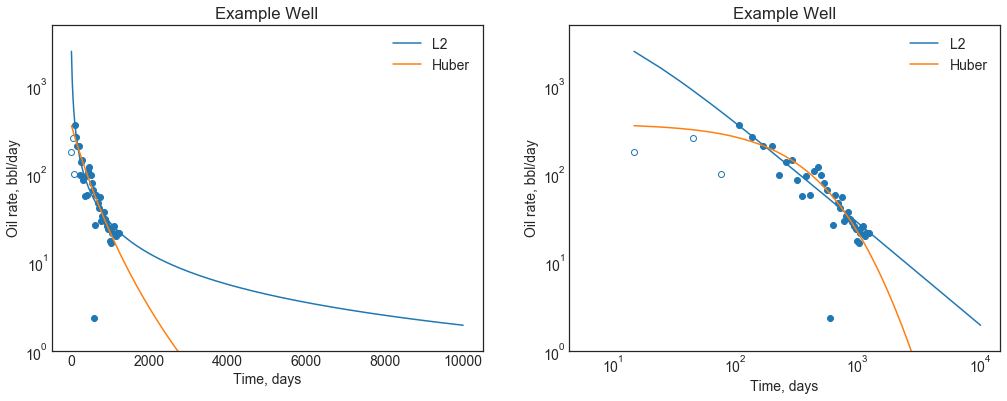

In [17]:
fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.scatter(fit_time, fit_rate)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
plt.semilogy(forecast_time, y_L2_dca, label='L2')
plt.semilogy(forecast_time, y_Huber_dca, label='Huber')

plt.ylim(1, 5e3)
plt.ylabel('Oil rate, bbl/day')
plt.legend()
plt.xlabel('Time, days')
plt.title('Example Well')

ax2 = fig.add_subplot(122)
plt.scatter(fit_time, fit_rate)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
plt.loglog(forecast_time, y_L2_dca, label='L2')
plt.loglog(forecast_time, y_Huber_dca, label='Huber')

plt.ylim(1, 5e3)
plt.ylabel('Oil rate, bbl/day')
plt.legend()
plt.xlabel('Time, days')
plt.title('Example Well')

plt.show()

Well, that's quite obviously much more linear. We also have an outlier that becomes apparent after the log transform even though it was not an issue before. Let's ignore it for now and re-fit. We can use the same lines of code as before, just adjust our lambda function to calculate the residuals on the logs!

In [18]:
L2_dca2 = sc.optimize.least_squares(fun=lambda parms, time, rate: np.log(rate) - np.log(forecast(time, parms)),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time, fit_rate),
                                   loss='linear')
Huber_dca2 = sc.optimize.least_squares(fun=lambda parms, time, rate: np.log(rate) - np.log(forecast(time, parms)),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time, fit_rate),
                                   loss='soft_l1', f_scale=.35)

y_L2_dca2 = forecast(forecast_time, L2_dca2.x)
y_Huber_dca2 = forecast(forecast_time, Huber_dca2.x)

In [19]:
pd.DataFrame([secant_dec(L2_dca2.x), secant_dec(Huber_dca2.x)], columns=[r'$q_i$', r'$D_{eff}$', r'$b$'], index=['L2','Huber'])

$q_i$  $D_{eff}$    $b$
L2     10000.000     99.170  0.806
Huber   1053.622     91.013  0.667

Let's also run a linear model for comparison. Fitting the a linear model to the logs of the data results in a power-law model:

$$
\begin{align}
q & = bx^m \\
\text{ln} \; q & = \text{ln} \; bx^m \\
\text{ln} \; q & = \text{ln} \; b + m \, \text{ln} \; x
\end{align}
$$

If we recall that the hyperbolic equation is:

$$
q = q_i \, (1+D_i \, b \, t)^\frac{-1}{b} \\
\text{ln} \; q = \text{ln} \; q_i \, (1+D_i \, b \, t)^\frac{-1}{b} \\
\text{ln} \; q = \text{ln} \; q_i -  \frac{1}{b}\text{ln} \; (1+D_i \, b \, t)
$$

Then by comparison of the two models it's obvious that $m=\frac{-1}{b}$.

In [20]:
# Setup our regression matrices
X0 = np.ones(shape=(fit_time.shape[0],2))
X0[:,1] = np.log(fit_time).ravel()
X0 = np.asmatrix(X0)
Y0 = np.asmatrix(np.log(fit_rate)[:,None])

# Calculate the least squares solution, @ is the matrix multiplication operator
w0 = (X0.T @ X0).I @ X0.T @ Y0

# Setup forecast time matrix
X1 = np.ones(shape=(forecast_time.shape[0],2))
X1[:,1] = np.log(forecast_time).ravel()
X1 = np.asmatrix(X1)

pd.DataFrame(-1/w0[1], columns=[''], index=['OLS Regression $b =$'])

OLS Regression $b =$  0.822638

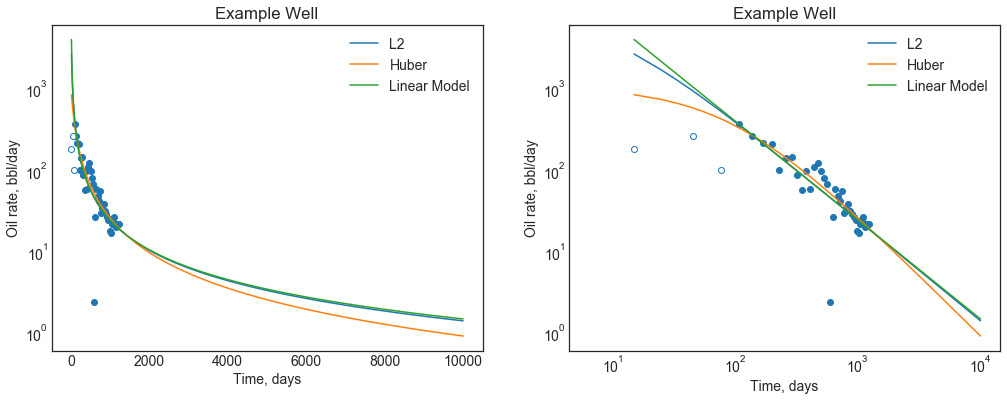

In [21]:
fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.scatter(fit_time, fit_rate)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
plt.semilogy(forecast_time, y_L2_dca2, label='L2')
plt.semilogy(forecast_time, y_Huber_dca2, label='Huber')
plt.semilogy(forecast_time, np.exp(X1 @ w0), label='Linear Model')
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

ax2 = fig.add_subplot(122)
plt.scatter(fit_time, fit_rate)
plt.scatter(filtered_time, filtered_rate, facecolor='white', edgecolor=colors[0])
plt.loglog(forecast_time, y_L2_dca2, label='L2')
plt.loglog(forecast_time, y_Huber_dca2, label='Huber')
plt.loglog(forecast_time, np.exp(X1 @ w0), label='Linear Model')
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

plt.show()

That's significantly improved, being much more linear! But we still have a significant difference with the L2 initial rate still at 10,000 BPD, and it doesn't improve over a simple linear model (meaning what's the point of a hyperbolic model in that case?). Let's look at the point-by-point cost. We define new functions that compute the cost on the logs, and a geometric mean function to compute the averages.

In [22]:
def single_log_L2cost(parms, time, rate, idx):
    Yhat = forecast(np.array([time[idx]]), parms)
    return 1/2 * np.sum(  (np.log(rate[idx]) - np.log(Yhat))**2  )

def single_log_Hcost(parms, time, rate, idx):
    Yhat = forecast(np.array([time[idx]]), parms)
    return np.sum(  (np.sqrt(1 + (np.log(rate[idx]) - np.log(Yhat))**2) - 1)  )

def geo_mean(x):
    return np.exp(np.log(x).mean())

L2_log_cost = [single_log_L2cost(L2_dca.x, fit_time, fit_rate, idx) for idx in range(len(fit_time))]
Huber_log_cost = [single_log_Hcost(Huber_dca.x, fit_time, fit_rate, idx) for idx in range(len(fit_time))]

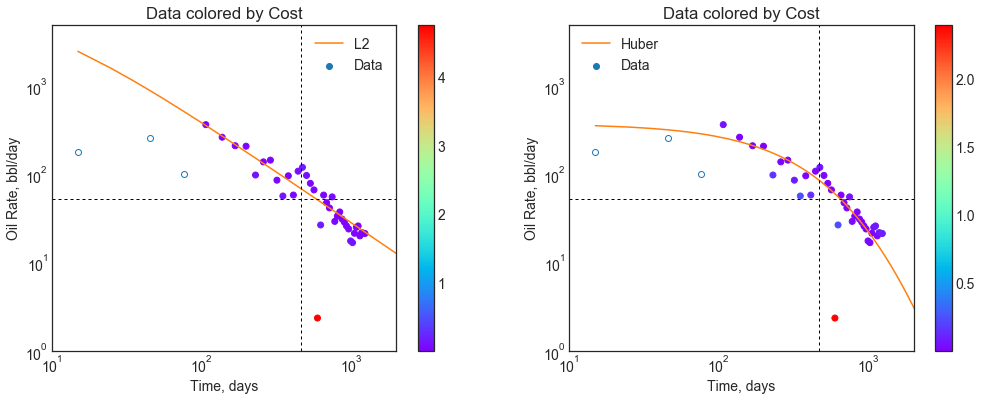

In [23]:
# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(17,6))
ax1 = fig.add_subplot(121)
plt.scatter(time[:3], rate[:3], facecolor='white', edgecolor=colors[0])
# cbar = plt.scatter(fit_time, fit_rate, c=H_ii, cmap='rainbow', label='Data')
cbar = plt.scatter(fit_time, fit_rate, c=np.abs(L2_log_cost), cmap='rainbow', label='Data')
fig.colorbar(cbar)
plt.loglog(forecast_time, y_L2_dca, c=colors[1], label='L2')
plt.axhline(geo_mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(geo_mean(time), c='k', lw=1, ls=(0,(3,3)))
plt.legend()

plt.ylim(1, 5e3)
plt.xlim(10, 2e3)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')

ax2 = fig.add_subplot(122)
plt.scatter(time[:3], rate[:3], facecolor='white', edgecolor=colors[0])
cbar2 = plt.scatter(fit_time, fit_rate, c=np.abs(Huber_log_cost), cmap='rainbow', label='Data')
fig.colorbar(cbar2)
plt.loglog(forecast_time, y_Huber_dca, c=colors[1], label='Huber')
plt.axhline(geo_mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(geo_mean(time), c='k', lw=1, ls=(0,(3,3)))
plt.ylim(1, 5e3)
plt.xlim(10, 2e3)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')
plt.legend()

plt.show()

### Filter Outlier
Well, the outlier point's impact on the regression is rather large. Let's go ahead and remove it, and refit once again.

In [24]:
filtered_time2 = np.append(filtered_time, fit_time[fit_rate<10])
filtered_rate2 = np.append(filtered_rate, fit_rate[fit_rate<10])
fit_time2 = fit_time[fit_rate>10.]
fit_rate2 = fit_rate[fit_rate>10.]

In [25]:
parm_init = np.asarray([200, .001, 1.])
L2_dca_l = sc.optimize.least_squares(fun=lambda parms, time, rate: np.log(rate) - np.log(forecast(time, parms)),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time2, fit_rate2),
                                   loss='linear')
Huber_dca_l = sc.optimize.least_squares(fun=lambda parms, time, rate: np.log(rate) - np.log(forecast(time, parms)),
                                   bounds=([10, 1e-6, 0], [10000, 1e6, 2]),
                                   x0=parm_init, args=(fit_time2, fit_rate2),
                                   loss='soft_l1')

y_L2_dca_l = forecast(forecast_time, L2_dca_l.x)
y_Huber_dca_l = forecast(forecast_time, Huber_dca_l.x)

In [26]:
pd.DataFrame([secant_dec(L2_dca_l.x), secant_dec(Huber_dca_l.x)], columns=[r'$q_i$', r'$D_{eff}$', r'$b$'], index=['L2','Huber'])

$q_i$  $D_{eff}$    $b$
L2     796.186     87.949  0.620
Huber  795.086     87.861  0.616

In [27]:
# Setup our regression matrices
X0 = np.ones(shape=(fit_time2.shape[0],2))
X0[:,1] = np.log(fit_time2).ravel()
X0 = np.asmatrix(X0)
Y0 = np.asmatrix(np.log(fit_rate2)[:,None])

# Calculate the least squares solution, @ is the matrix multiplication operator
w0 = (X0.T @ X0).I @ X0.T @ Y0

pd.DataFrame(-1/w0[1], columns=[''], index=['OLS Regression $b =$'])

OLS Regression $b =$  0.829424

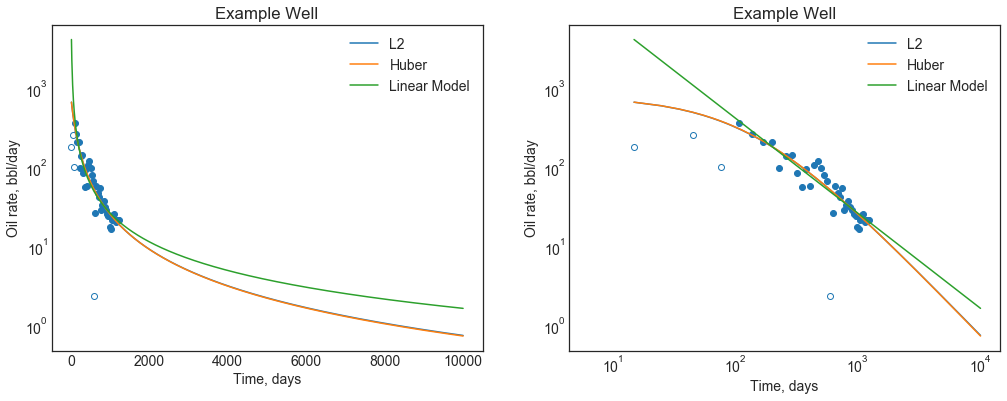

In [28]:
fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
plt.semilogy(forecast_time, y_L2_dca_l, label='L2')
plt.semilogy(forecast_time, y_Huber_dca_l, label='Huber')
plt.semilogy(forecast_time, np.exp(X1 @ w0), label='Linear Model')
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

ax2 = fig.add_subplot(122)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
plt.loglog(forecast_time, y_L2_dca_l, label='L2')
plt.loglog(forecast_time, y_Huber_dca_l, label='Huber')
plt.loglog(forecast_time, np.exp(X1 @ w0), label='Linear Model')
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

plt.show()

And finally we get convergence! Once the outliers are removed, the L2 nearly falls ontop of the Huber... which indicates that the Huber is very close to our "best-fit" even in the presence of outliers, just as we saw on the harmonic oscilliation example where we knew exactly what the true model was.

In [29]:
L2_log_cost2 =[single_log_L2cost(L2_dca_l.x, fit_time2, fit_rate2, idx) for idx in range(len(fit_time2))]
Huber_log_cost2 = [single_log_Hcost(Huber_dca_l.x, fit_time2, fit_rate2, idx) for idx in range(len(fit_time2))]

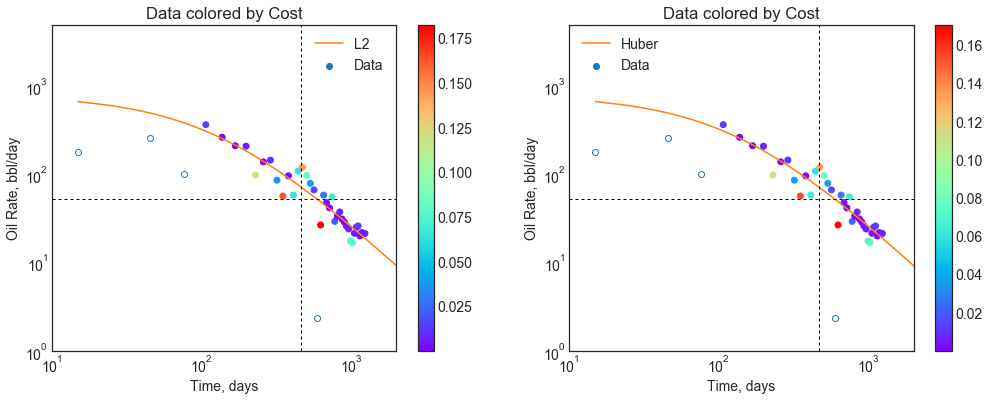

In [30]:
# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(17,6))
ax1 = fig.add_subplot(121)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
# cbar = plt.scatter(fit_time, fit_rate, c=H_ii, cmap='rainbow', label='Data')
cbar = plt.scatter(fit_time2, fit_rate2, c=np.abs(L2_log_cost2), cmap='rainbow', label='Data')
fig.colorbar(cbar)
plt.loglog(forecast_time, y_L2_dca_l, c=colors[1], label='L2')
plt.axhline(geo_mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(geo_mean(time), c='k', lw=1, ls=(0,(3,3)))
plt.legend()

plt.ylim(1, 5e3)
plt.xlim(10, 2e3)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')

ax2 = fig.add_subplot(122)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
cbar2 = plt.scatter(fit_time2, fit_rate2, c=np.abs(Huber_log_cost2), cmap='rainbow', label='Data')
fig.colorbar(cbar2)
plt.loglog(forecast_time, y_Huber_dca_l, c=colors[1], label='Huber')
plt.axhline(geo_mean(rate), c='k', lw=1, ls=(0,(3,3)))
plt.axvline(geo_mean(time), c='k', lw=1, ls=(0,(3,3)))

plt.ylim(1, 5e3)
plt.xlim(10, 2e3)
plt.xlabel('Time, days')
plt.ylabel('Oil Rate, bbl/day')
plt.title('Data colored by Cost')
plt.legend()

plt.show()

And we see that there is a reasonable coloration of points and colorbar scale between the two, indicating there's nothing further we can do to "clean-up" this data set. Still, though, there is considerable noise in the data. How can we be sure that this "best-fit" is the "best forecast"?

We can't. Our simple hyperbolic model is purely empirical and, although it has stood the test of time, we know that it breaks down in very easy to show ways. In addition to not capturing the early-time build-up period, it also does not reproduce any transient-to-boundary dominated physics. It grossly overpredicts reserves when not bounded, and will predict infinite reserves for $b>=1$. Additionally, we know it is non-unique. Additional production history may alter the fit parameters in not-subtle ways.

While it requires a more complex moodel and stochastic method to adress these issues, we can explore a cost function that reduces the sensitivity to outliers *and* leverage points.

### SPE-174784-PA Cost Function
The cost function we presented in SPE-174784-PA has four advantageous features:
1. It operates on the log residuals.
2. It uses L1 cost for robustness.
3. It is regularized for variance of the residuals.
4. It cost function is calculated as a delta from the *best model*, not just from the observed reponse variable.

Point 4\. indicates that a notion of best model must be known or found before the cost function works properly. While we are not going to reproduce the probabilistic forecasting method here, we can simply cheat and use the Huber fit as our "best model" from which we'll evaluate other fits.

We define the loss and calculate the error of the Huber model as the value of the best model.

In [31]:
def p_loss(parms, time, rate, min_eps):
    time = np.array(time)
    Yhat = forecast(time, parms)
    res = np.log1p(rate) - np.log1p(Yhat)
    eps1 = np.mean(np.abs(res))
    eps2 = np.std(res)
    return (eps1-min_eps[0])**2/.1**2 + (eps2-min_eps[1])**2/.01**2

def calc_min_eps(parms, time, rate):
    time = np.array(time)
    Yhat = forecast(time, parms)
    res = np.log1p(rate) - np.log1p(Yhat)
    eps1 = np.mean(np.abs(res))
    eps2 = np.std(res)
    return (eps1, eps2)

min_eps = calc_min_eps(Huber_dca_l.x, fit_time2, fit_rate2)

We'll run the optimization from several fixed points of initial rate.

In [32]:
p_dca = []
init_qi = np.arange(200,2000+100,100)
parm_init_r = np.copy(parm_init)
for arg1 in init_qi:
    parm_init_r[0] = arg1
    fit = sc.optimize.minimize(fun=p_loss, bounds=((arg1,arg1),(1e-6,1),(0,2)), x0=parm_init_r,
                               args=(fit_time2, fit_rate2, min_eps), tol=1e-40)
    p_dca.append(fit)

And one unconstrained fit.

In [33]:
parm_init_r[0] = 1000
fit = sc.optimize.minimize(fun=p_loss, bounds=((1,1e5),(1e-6,1),(0,2)), x0=parm_init_r,
                           args=(fit_time2, fit_rate2, min_eps), tol=1e-40)
p_dca.append(fit)

In [34]:
# init_qi_text = np.array([r'$q_i=200$', r'$q_i=400$', r'$q_i=600$', r'$q_i=800$', r'$q_i=1000$', r'$q_i=1500$'])[:,None]
init_qi_text = np.array([r'$q_i=' + str(qi) + '$' for qi in init_qi])[:,None]
init_qi_text = np.vstack([init_qi_text, r'Unconstriained'])
pd.DataFrame(np.hstack([init_qi_text, [secant_dec(parms.x) for parms in p_dca]]),
             columns=['Initial Guess', r'$q_i$', r'$D_{eff}$', r'$b$'], index=['' for i in range(len(p_dca))])

Initial Guess   $q_i$ $D_{eff}$    $b$
       $q_i=200$   200.0    65.594  0.245
       $q_i=300$   300.0    71.736  0.356
       $q_i=400$   400.0    76.833  0.438
       $q_i=500$   500.0    80.732  0.501
       $q_i=600$   600.0    83.763   0.55
       $q_i=700$   700.0    86.074  0.589
       $q_i=800$   800.0    87.119  0.608
       $q_i=900$   900.0    89.408  0.645
      $q_i=1000$  1000.0    89.824  0.652
      $q_i=1100$  1100.0    90.773  0.668
      $q_i=1200$  1200.0    91.547  0.681
      $q_i=1300$  1300.0    92.207  0.691
      $q_i=1400$  1400.0    92.783    0.7
      $q_i=1500$  1500.0    93.309   0.71
      $q_i=1600$  1600.0    93.754  0.718
      $q_i=1700$  1700.0    94.144  0.724
      $q_i=1800$  1800.0    94.489   0.73
      $q_i=1900$  1900.0    94.796  0.735
      $q_i=2000$  2000.0    95.068   0.74
  Unconstriained  999.93    89.823  0.652

Interestingly, only the first guess had the fit $q_i$ deviate any significant amount. The indiciation here is that *any* of these values of initial rate may be the correct one! Let's look at a plot to understand this more clearly.

In [35]:
y_p_dca = np.array([forecast(forecast_time, fit.x) for fit in p_dca])

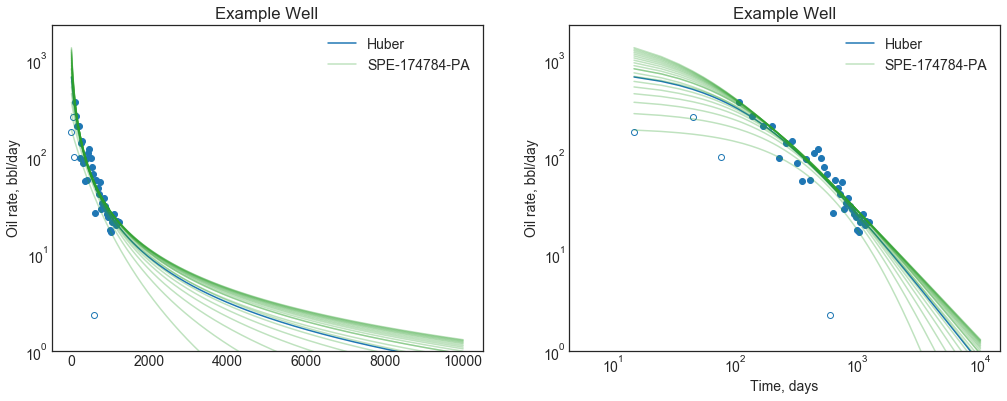

In [36]:
fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
# plt.semilogy(forecast_time, y_L2_dca_l, label='L2')
plt.semilogy(forecast_time, y_Huber_dca_l, label='Huber')
plt.semilogy(forecast_time, y_p_dca[0], color=colors[2], alpha=.3, label='SPE-174784-PA')
plt.semilogy(forecast_time, y_p_dca[1:len(y_p_dca)].T, color=colors[2], alpha=.3)
plt.ylim(1,None)
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

ax2 = fig.add_subplot(122)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
# plt.loglog(forecast_time, y_L2_dca_l, label='L2')
plt.loglog(forecast_time, y_Huber_dca_l, label='Huber')
plt.loglog(forecast_time, y_p_dca[0], color=colors[2], alpha=.3, label='SPE-174784-PA')
plt.loglog(forecast_time, y_p_dca[1:len(y_p_dca)].T, color=colors[2], alpha=.3)
plt.ylim(1,None)
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

plt.show()

Looking at the result helps understand what is occuring. The non-uniqueness is due to the fact that all the models may converge from different starting conditions, each provides very nearly the same behavior during the time window of production history, and then they diverge. This is a very different conclusion than what we may have reached if we simply stopped with the more simple cost functions, where it seemed both eventually converged to the same "correct" answer. The intial condition of $q_i =$ 800 BPD also returned the same fit as the Huber/L2.

We can look at the point-by-point cost to see the weighting of data points.

In [37]:
def p_single_loss(parms, time, rate, min_eps, idx):
    Yhat = forecast(np.array([time[idx]]), parms)
    res = np.log(rate[idx]) - np.log(Yhat)
    eps1 = np.mean(np.abs(res))
    eps2 = np.std(res)
    return (eps1-min_eps[0])**2/.1**2 #+ (eps2-min_eps[1])**2/.01**2

p_cost = [np.array([p_single_loss(fit.x, fit_time2, fit_rate2, min_eps, idx) for idx in range(len(fit_time2))]) \
                       for fit in p_dca]

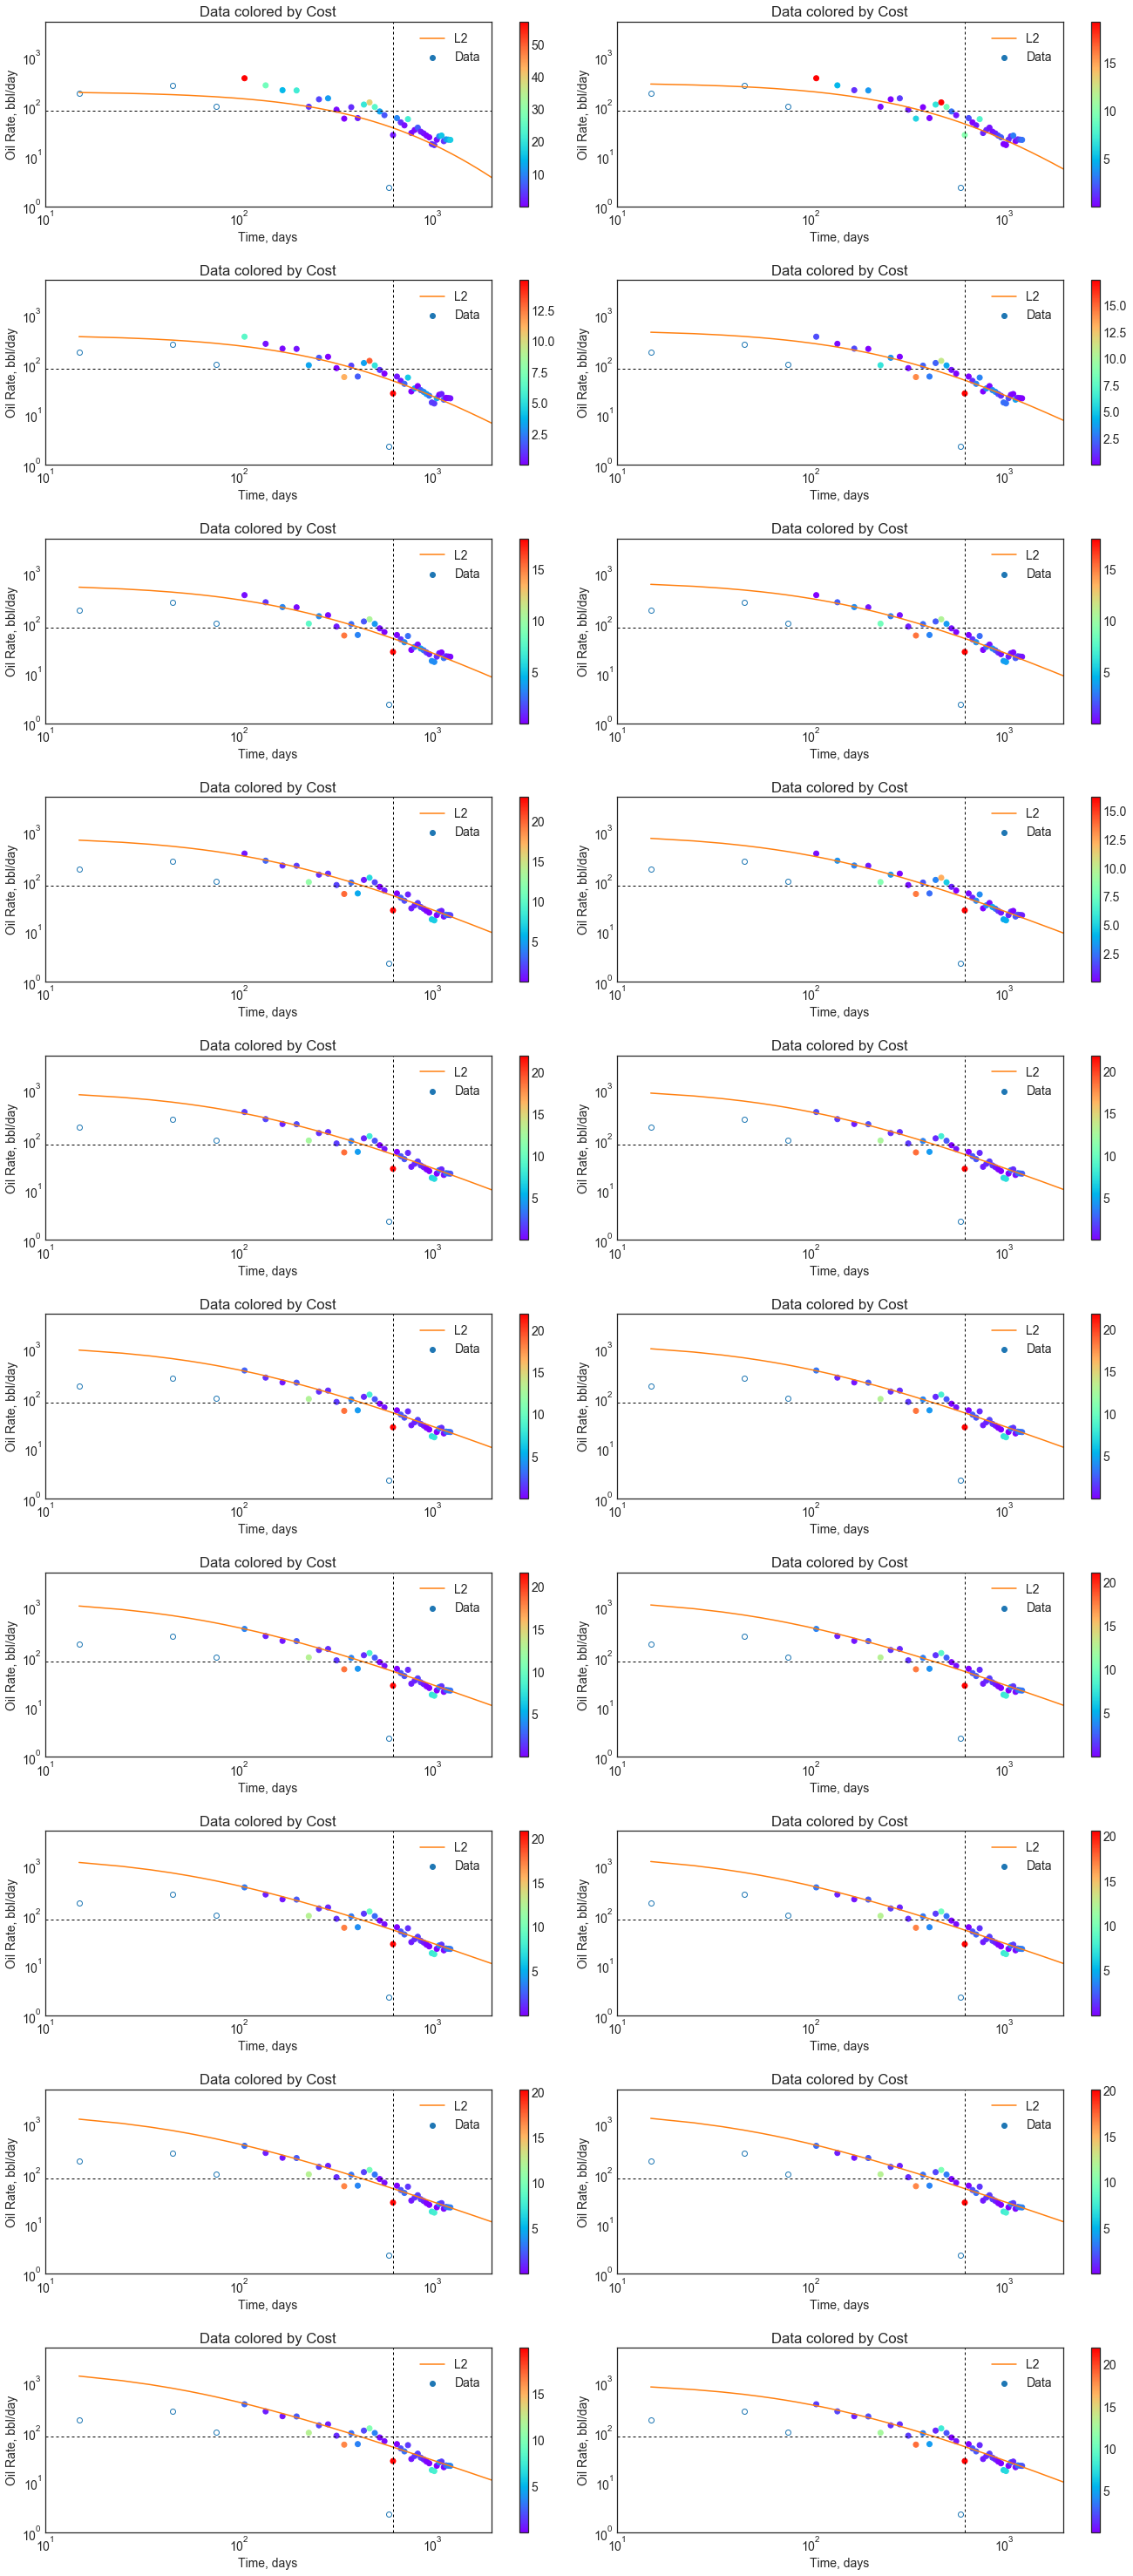

In [38]:
# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(18,40))
for i, (f_rate, f_cost) in enumerate(zip(y_p_dca, p_cost)):
    fig.add_subplot(len(p_cost)//2+len(p_cost)%2, 2, i+1)
    plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
    # cbar = plt.scatter(fit_time, fit_rate, c=H_ii, cmap='rainbow', label='Data')
    cbar = plt.scatter(fit_time2, fit_rate2, c=np.abs(f_cost), cmap='rainbow', label='Data')
    plt.colorbar(cbar)
    plt.loglog(forecast_time, f_rate, c=colors[1], label='L2')
    plt.axhline(np.mean(rate), c='k', lw=1, ls=(0,(3,3)))
    plt.axvline(np.mean(time), c='k', lw=1, ls=(0,(3,3)))
    plt.legend()
    plt.gca().set(ylim=(1, 5e3), xlim=(10, 2e3), xlabel=('Time, days'), ylabel=('Oil Rate, bbl/day'),
           title=('Data colored by Cost'))

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=.025, hspace=.4)
plt.show()

And these mostly look the same, even though there are very different starting conditions and each diverges later in time.

We'll take a look at the surface of the cost function to visualize why this occurs. First, we need to build a mesh and evaluate the model cost over the entire mesh. Let's start with the Huber cost first. Recalling the prediction and Huber cost function (which we're actually using the the Soft L1 approximation so that we can a continuous function):

```
def forecast(time, args):
    qi = args[0]; Di = args[1]; b = args[2]
    q = qi / (1 + Di * b * time) ** (1 / b)
    return q

def Hcost(parms, time, rate):
    Yhat = forecast_opt(time, parms)
    return np.sum(  (np.sqrt(1 + (rate - Yhat)**2) - 1)  )
```

Which is easy enough. Let's derive the Jacobian. We define the the Huber cost function in Sympy:

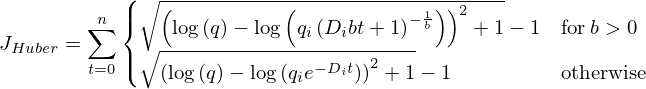

In [39]:
q = sym.Symbol('q', real=True, positive=True)
n = sym.Symbol('n', real=True, positive=True)
J_H = sym.Symbol('J_{Huber}', real=True, positive=True)
res_sym = sym.log(q) - sym.log(arpsq)
Hcost_sym = sym.sqrt(1+(res_sym)**2)-1
Hcost_eq = sym.Eq(J_H,sym.Sum(Hcost_sym, (t, 0, n)))
display(Hcost_eq)

Which looks correct. Let's take the partial derivatives:

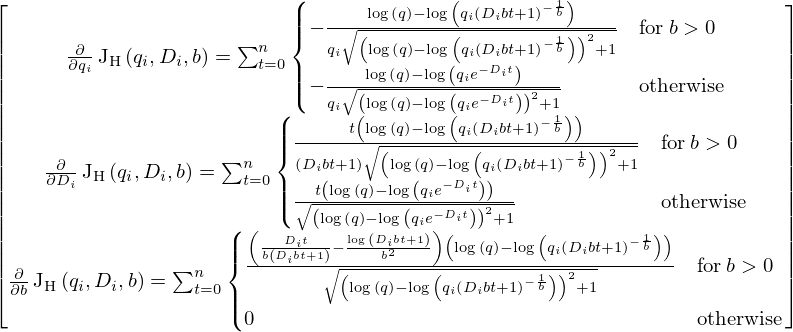

In [40]:
H_jac = sym.Matrix([sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),qi),sym.Sum(sym.diff(Hcost_sym,qi), (t, 0, n))),
            sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),Di),sym.Sum(sym.diff(Hcost_sym,Di), (t, 0, n))),
            sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),b),sym.Sum(sym.diff(Hcost_sym,b), (t, 0, n)))])
display(H_jac)

Which is somewhat ugly. Let's restrict b to be a postive non-zero number, which limits us to the hyperbolic case.

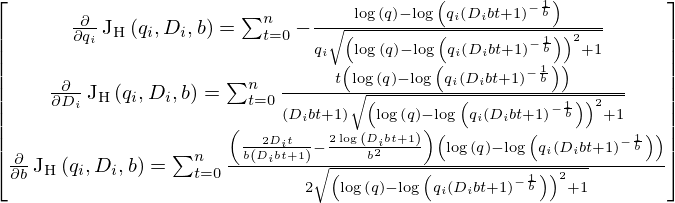

In [41]:
arps_hyp = qi / (1 + Di * b * t) ** (1 / b)
res_sym = sym.log(q) - sym.log(arps_hyp)
Hcost_sym = sym.sqrt(1+(res_sym)**2)-1
H_jac = sym.Matrix([sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),qi),sym.Sum(sym.diff(Hcost_sym,qi), (t, 0, n))),
            sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),Di),sym.Sum(sym.diff(Hcost_sym,Di), (t, 0, n))),
            sym.Eq(sym.diff(sym.Function('J_H')(qi, Di, b),b),sym.Sum(sym.diff(Hcost_sym,b), (t, 0, n)))])
display(H_jac)

Which is still ugly. Let's simplify the expresion by separating it by the two parts of the chain rule:

$$
\frac{dy}{dx} = \frac{dy}{du}\frac{du}{dx} \\[1.5em]
or \\[1.5ex]
f'(x) = f'\big(g(x)\big) \; g'(x)
$$

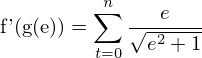

In [42]:
e = sym.Symbol('e', real=True)
fgx = sym.Function('f\'(g(e))')
g = sym.Symbol('g', real=True)
gx = sym.Function('g\'(e)')
sym.Eq(fgx,sym.diff(sym.Sum(sym.sqrt(1+(e)**2)-1,(t,0,n)), e))

And substituting the residual:

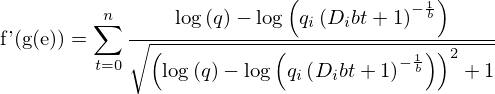

In [43]:
sym.Eq(fgx,sym.diff(sym.Sum(sym.sqrt(1+(e)**2)-1,(t,0,n)), e).subs(e,res_sym))

Evaluating $g'$:

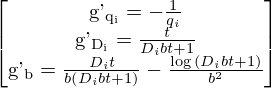

In [44]:
gxq = sym.Function('g\'_{q_i}')
gxD = sym.Function('g\'_{D_i}')
gxb = sym.Function('g\'_b')
sym.Matrix([sym.Eq(gxq,sym.diff(res_sym, qi)),
            sym.Eq(gxD,sym.diff(res_sym, Di)),
            sym.Eq(gxb,sym.diff(res_sym, b))])

Much better! This is reasonable to write in code rather than use the symbolic evaluation, as it is ***much*** faster to do so. Recalling the total derivative is:

$$
\nabla J_{Huber}(q_i, D_i, b) = \frac{\partial J_{Huber}}{\partial q_i} + \frac{\partial J_{Huber}}{\partial D_i} + \frac{\partial J_{Huber}}{\partial b_i}
= f'g \left[ g'_{q_i} + g'_{D_i} + g'_b \right]
$$

In [45]:
def Huber_g(parms, time, rate):
    #This function is optimized to avoid repeat operations
    qi = parms[0]; Di = parms[1]; b = parms[2]
    if b < 1e-4:
        b = 1e-4
    Dibt_1     = Di * b * time + 1
    qt         = qi * Dibt_1 ** (- 1 / b)
    residual   = np.log(rate) - np.log(qt)
    f_prime_g  = residual / (np.sqrt(residual**2+1))
    partial_q  = - 1 / qi
    partial_Di = time / Dibt_1
    partial_b  = Di * time / (b * Dibt_1) - 1 / b**2 * np.log(Dibt_1)
    gradient   = f_prime_g * (partial_q + partial_Di + partial_b)
    return np.sum(gradient)

Here we define our mesh. We calculate our forecasts with nominal decline, which is highly non-linear such that a double exponential is needed to decently linearize it so that our mesh of secant decline is not highly skewed! We also maintain our original non-mesh arrays for some computations later, and convert nominal decline to secant effective.

In [46]:
qmesh0 = np.exp(np.linspace(np.log(200), np.log(2000), 100))
Dmesh0 = np.exp(np.exp(np.linspace(np.log(1), np.log(6.5), 40))-6.5)
Dmesh_nom0 = Dmesh0
Dmesh_sec0 = np.linspace(60,100,40)
qmesh, Dmesh = np.meshgrid(qmesh0, Dmesh0)
qmesh, Dmesh_sec = np.meshgrid(qmesh0, Dmesh_sec0)
Dmesh_nom = Dmesh

Step over our mesh to find the optimum $b$-parameter at each point.

In [47]:
# Evaluate points
zmesh_H = []
Huber_opt = []
for init_q, init_D in zip(qmesh.ravel(), Dmesh_nom.ravel()):
    opt = sc.optimize.least_squares(fun=lambda parms, time, rate: \
                                   np.log(rate) - np.log(forecast(time, [init_q, init_D, parms])),
                                   bounds=([1e-3], [2]),
                                   x0=[1], args=(fit_time2, fit_rate2),
                                   loss='soft_l1') 
    Huber_opt.append([init_q, init_D, opt.x])
    zmesh_H.append(Hcost([init_q, init_D, opt.x], fit_time2, fit_rate2))
Huber_opt = np.array(Huber_opt)    
zmesh_H = np.array(zmesh_H).reshape(qmesh.shape[0],-1)

bmesh_H = Huber_opt[:,2].reshape(qmesh.shape[0],-1)

Calculate secant effective decline over our nominal decline mesh using the optimize $b$-parameter.

In [48]:
Dmesh_H = (1 - (1 + Dmesh_nom * bmesh_H * 365.25) ** (-1 /bmesh_H))*100

Calculate the costs of our prior best-fits for plotting.

In [49]:
z_H = np.array([Hcost(Huber_dca_l.x, fit_time2, fit_rate2)])
z_R = np.array([Hcost(fit.x, fit_time2, fit_rate2) for fit in p_dca])
sec_H = secant_dec(Huber_dca_l.x)
sec_R = np.array([secant_dec(fit.x) for fit in p_dca])
temp = np.msort(sec_R[:-1,:])
sec_R = np.vstack([temp, sec_R[-1,:]])

In [50]:
zmesh_H[zmesh_H>8000]=8000

Let's plot the surface, and the points of our fit models on that surface.

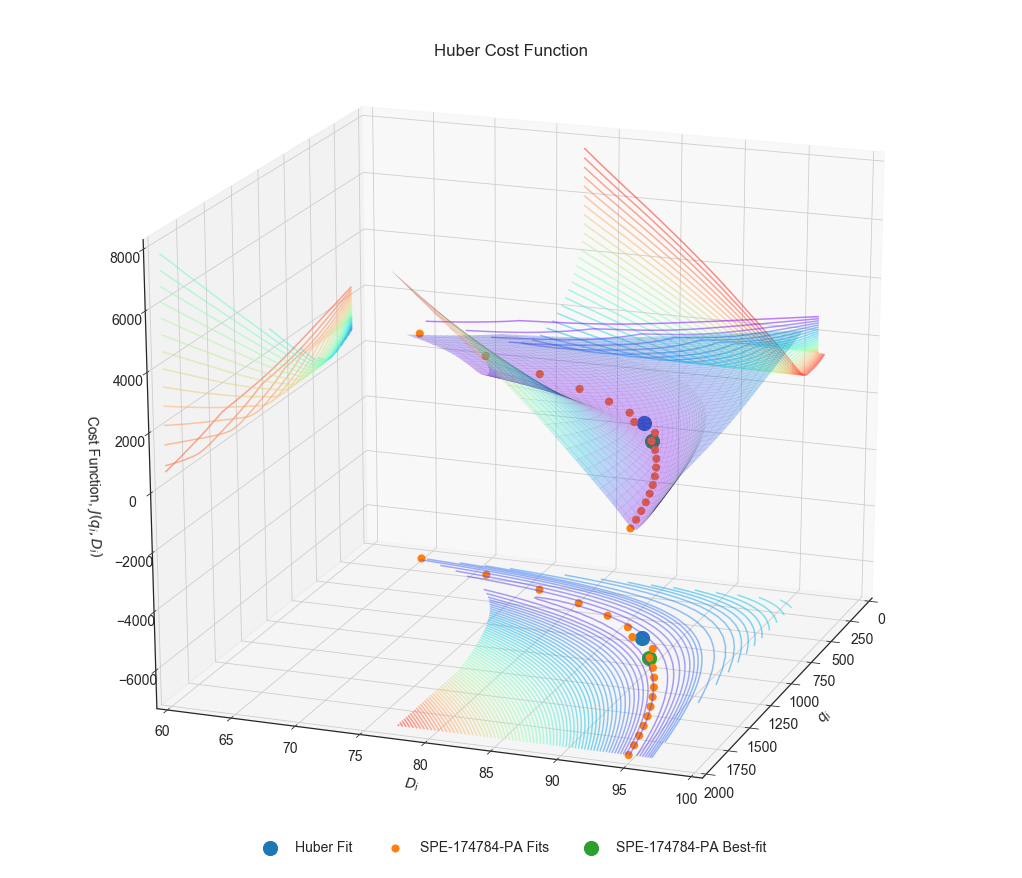

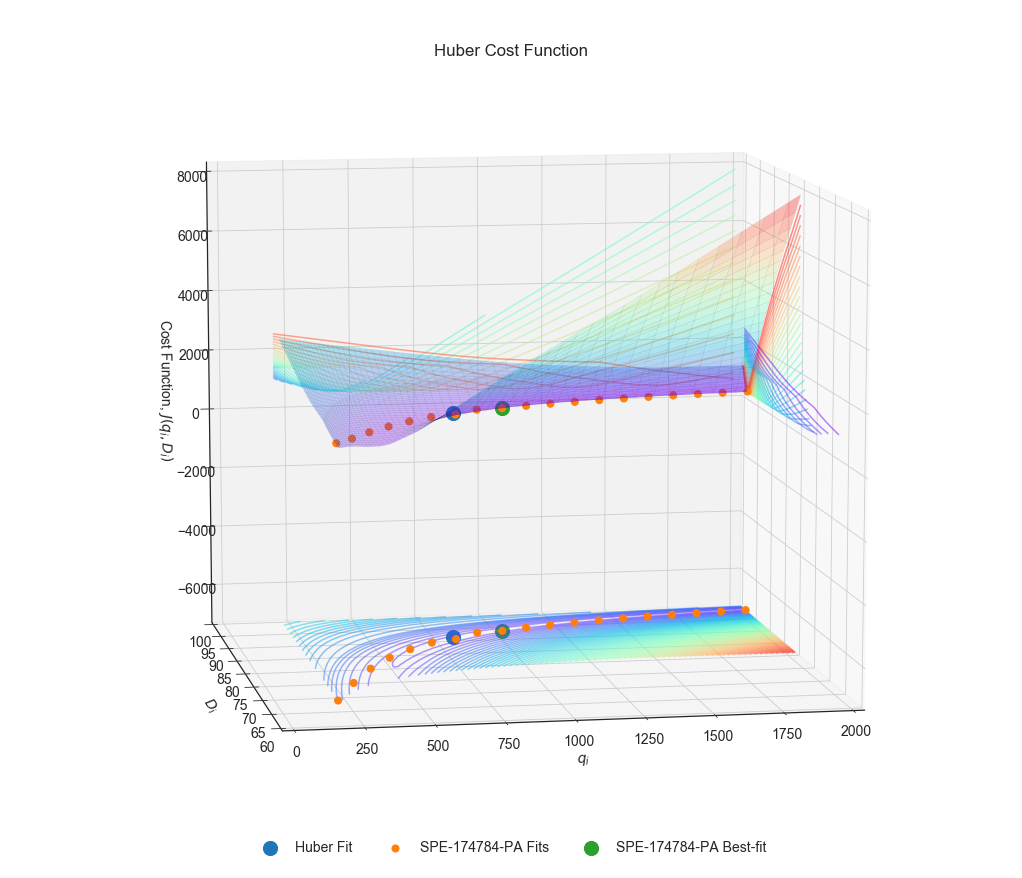

In [51]:
mpl.rcParams['font.size'] = 14
def cost_3D(elev, azim, xoff, yoff, zoff):
    fig = plt.figure(figsize=(14,12))
    ax = plt3d.Axes3D(fig)

    # Plot the Cost Function
    ax.plot_surface(qmesh, Dmesh_H, zmesh_H, cmap='rainbow', alpha=.3, lw=.1, edgecolor='k', antialiased=True)

    # Plot the model fit
    ax.scatter(sec_H[0], sec_H[1], z_H, s=200, alpha=1, label='Huber Fit')
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], z_R[:-1], c=colors[1], s=50, alpha=1, label='SPE-174784-PA Fits')
    ax.scatter(sec_R[-1,0], sec_R[-1,1], z_R[-1], c=colors[2], s=200, alpha=1, label='SPE-174784-PA Best-fit')
    # ax.scatter(x, y, zmin, c=zd, s=50, cmap='rainbow', alpha=1, vmin=np.min(zdmesh), vmax=np.max(zdmesh))

    # Add counter lines to the axes planes
    ax.contour(qmesh, Dmesh_H, zmesh_H, zdir='z', cmap='rainbow', alpha=.5, levels=np.linspace(0,8000,75), offset=zoff)
    ax.contour(qmesh, Dmesh_H, zmesh_H, zdir='x', cmap='rainbow', alpha=.5, levels=np.linspace(200,2000,30), offset=xoff)
    ax.contour(qmesh, Dmesh_H, zmesh_H, zdir='y', cmap='rainbow', alpha=.5, levels=np.linspace(60,100,30), offset=yoff)
    ax.scatter(sec_H[0], sec_H[1], zoff, c=colors[0], s=200, alpha=1)
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zoff, c=colors[1], s=50, alpha=1)
    ax.scatter(sec_R[-1,0], sec_R[-1,1], zoff, c=colors[2], s=200, alpha=1)

    ax.set(xlim=(0,2000), ylim=(60,100), zlim=(zoff, 8000))
    ax.set_title(label='Huber Cost Function', pad=20)
    ax.set_xlabel(r'$q_i$', labelpad=10)
    ax.set_ylabel(r'$D_i$', labelpad=10)
    ax.set_zlabel(r'Cost Function, $J(q_i, D_i)$', labelpad=15)
    ax.view_init(elev=elev, azim=azim)
    plt.legend(ncol=10, bbox_to_anchor=(.5, .05), loc=9)

    plt.show()

cost_3D(20, 20, 0, 60, -7000)
cost_3D(10, 260, 2000, 100, -7000)

Interestingly, this surface has a valley that is quite flat! This means that ourHuber "best-fit" may not actually be the best-fit, but rather the optimization function cannot find a large enough gradient to determine in which direction to step the parameters to continue to solve (this is remediated by setting a high tolerance, but there is a cost to pay in computation time, and eventually we hit the limit of numerical precision). We also find that the SPE-1784784-PA fits fill along that valley even though the cost functon is quite different!

Let's compute and plot the gradient.

In [52]:
zdmesh_H = np.array([Huber_g(parms, fit_time2, fit_rate2) for parms in Huber_opt])
zdmesh_H = zdmesh_H.reshape(qmesh.shape[0], -1)

If we wanted to do it numerically, we would run the following code:

```
zdmesh_H = np.gradient(zmesh_H, qmesh0, axis=1)
zdmesh_H = zdmesh_H - np.gradient(zmesh_H, Dmesh_nom0*365.25, axis=0)
```

In [53]:
zd_H = np.array([Huber_g(Huber_dca_l.x, fit_time2, fit_rate2)])
zd_R = np.array([Huber_g(parms.x, fit_time2, fit_rate2) for parms in p_dca])

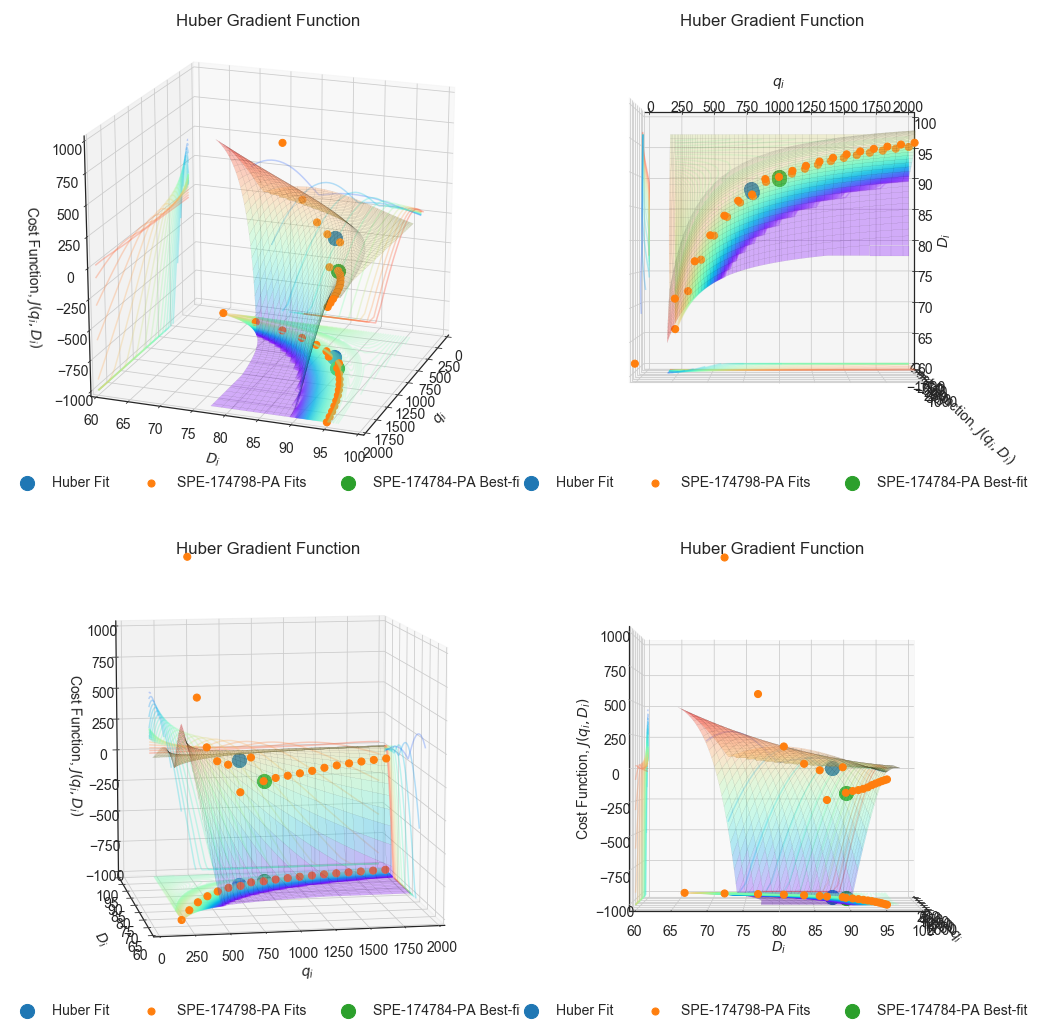

In [54]:
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(14,14))

def do_subplot(plot_num, elev, azim, zoff, xoff, yoff=100):
    zmax = 1000
    zdmesh_H[zdmesh_H<zoff]=zoff
    zdmesh_H[zdmesh_H>zmax]=zmax
    
    ax = fig.add_subplot('22' + str(plot_num), projection='3d')
    # Plot the Cost Function
    ax.plot_surface(qmesh, Dmesh_H, zdmesh_H, cmap='rainbow', alpha=.3, lw=.1, edgecolor='k', antialiased=True)
#     ax.plot_surface(qmesh, Dmesh_sec, np.zeros_like(qmesh), color=colors[0], alpha=.1, antialiased=True)
    ax.scatter(sec_H[0], sec_H[1], zd_H, s=200, c=colors[0], alpha=1., label='Huber Fit')
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zd_R[:-1], c=colors[1], s=50, alpha=1, label='SPE-174798-PA Fits')
    ax.scatter(sec_R[-1,0], sec_R[-1,1], zd_R[-1], c=colors[2], s=200, alpha=1, label='SPE-174784-PA Best-fit')
    # Add counter lines to the axes planes
    #levels = -np.flip(np.exp(np.linspace(0,np.log(np.abs(np.min(zdmesh_H))+np.max(zdmesh_H)),100)), axis=0)+np.max(zdmesh_H)
    ax.contour(qmesh, Dmesh_H, zdmesh_H, zdir='z', cmap='rainbow', alpha=.2, levels=np.linspace(zoff,zmax,300), offset=zoff)
    ax.contour(qmesh, Dmesh_H, zdmesh_H, zdir='x', cmap='rainbow', alpha=.3, levels=np.linspace(0,2000,15), offset=xoff)
    ax.contour(qmesh, Dmesh_H, zdmesh_H, zdir='y', cmap='rainbow', alpha=.3, levels=np.linspace(60,100,30), offset=yoff)
    ax.scatter(sec_H[0], sec_H[1], zoff, c=colors[0], s=200, alpha=1)
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zoff, c=colors[1], s=50, alpha=1)
    ax.scatter(sec_R[-1,0], sec_R[-1,1], zoff, c=colors[2], s=200, alpha=1)   
    
    ax.set(xlim=(0,2000), ylim=(60,100), zlim=(zoff, zmax))
    ax.set_title(label='Huber Gradient Function', pad=20)
    ax.set_xlabel(r'$q_i$', labelpad=10)
    ax.set_ylabel(r'$D_i$', labelpad=10)
    ax.set_zlabel(r'Cost Function, $J(q_i, D_i)$', labelpad=15)
    ax.view_init(elev=elev, azim=azim)
    plt.legend(ncol=3, bbox_to_anchor=(.5, .05), loc=9)

zmin = -1000
do_subplot(1, 20, 20, zmin, 0, 60)
do_subplot(2, 90, -90, zmin, 0, 60)
do_subplot(3, 10, 260, zmin, 2000)
do_subplot(4, 0, -0, zmin, 0, 60)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=.1)
plt.show()

We've clamped the gradient to a lower bound for plotting as it is very steep. On the corner towards $q_i=0$ and $D_i=100\%$ it becomes very flat - this is due to every forecast in that corner being essentially the same &mdash; effectively zero.

The "best-fit" doesn't exactly fall at a value of zero; but it is close. This is likely due to the fact that, while the gradient is large, the actual change in cost is rather small.

Let's repeat for the SPE-174784-PA cost function.

In [55]:
def p_loss2(init_b, init_q, init_D, time, rate, min_eps):
    return p_loss([init_q, init_D, init_b], time, rate, min_eps)

In [56]:
# Evaluate points
zmesh_R = []
Huber_opt_R = []
for init_q, init_D in zip(qmesh.ravel(), Dmesh_nom.ravel()):
    opt = sc.optimize.minimize(fun=p_loss2, bounds=((0,2),), x0=[1],
                               args=(init_q, init_D, fit_time2, fit_rate2, min_eps))   
    Huber_opt_R.append([init_q, init_D, opt.x])
    zmesh_R.append(p_loss([init_q, init_D, opt.x], fit_time2, fit_rate2, min_eps))
Huber_opt_R = np.array(Huber_opt_R)
zmesh_R = np.array(zmesh_R).reshape(qmesh.shape[0],-1)

bmesh_R = Huber_opt[:,2].reshape(qmesh.shape[0],-1)

In [57]:
Dmesh_R = (1 - (1 + Dmesh_nom * bmesh_R * 365.25) ** (-1 /bmesh_R))*100

In [58]:
z_H = np.array([p_loss(Huber_dca_l.x, fit_time2, fit_rate2, min_eps)])
z_R = np.array([p_loss(fit.x, fit_time2, fit_rate2, min_eps) for fit in p_dca])

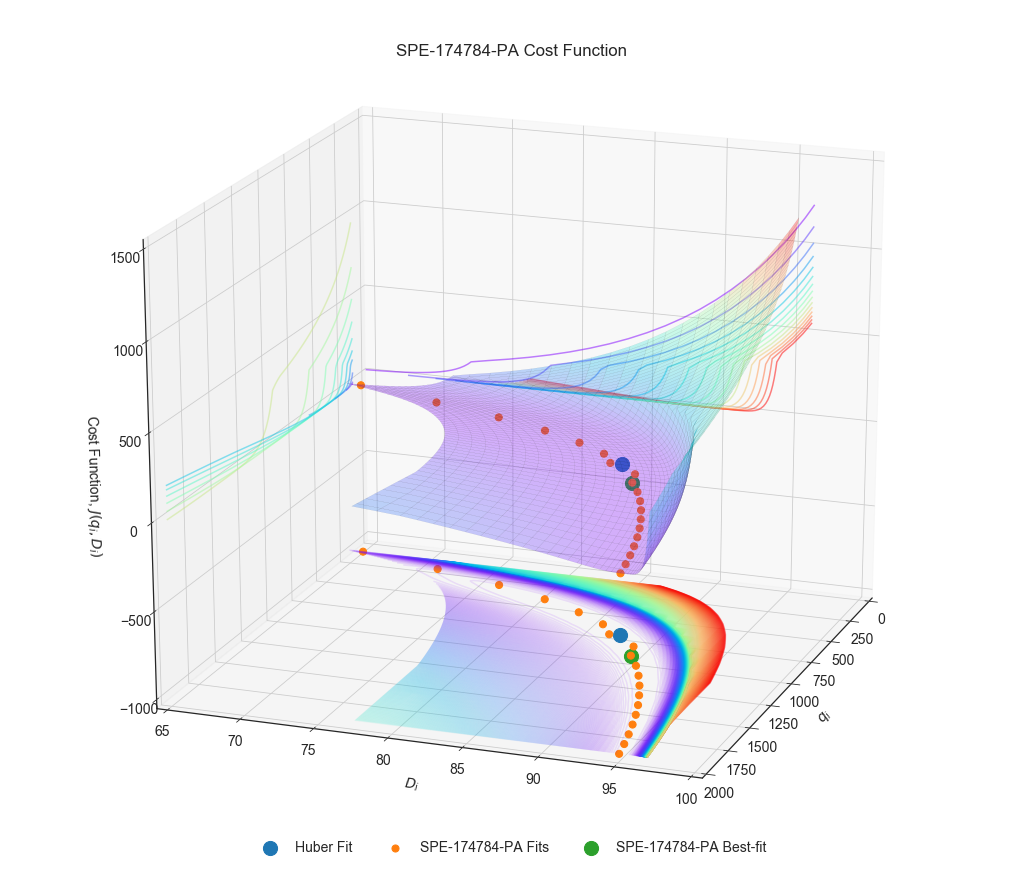

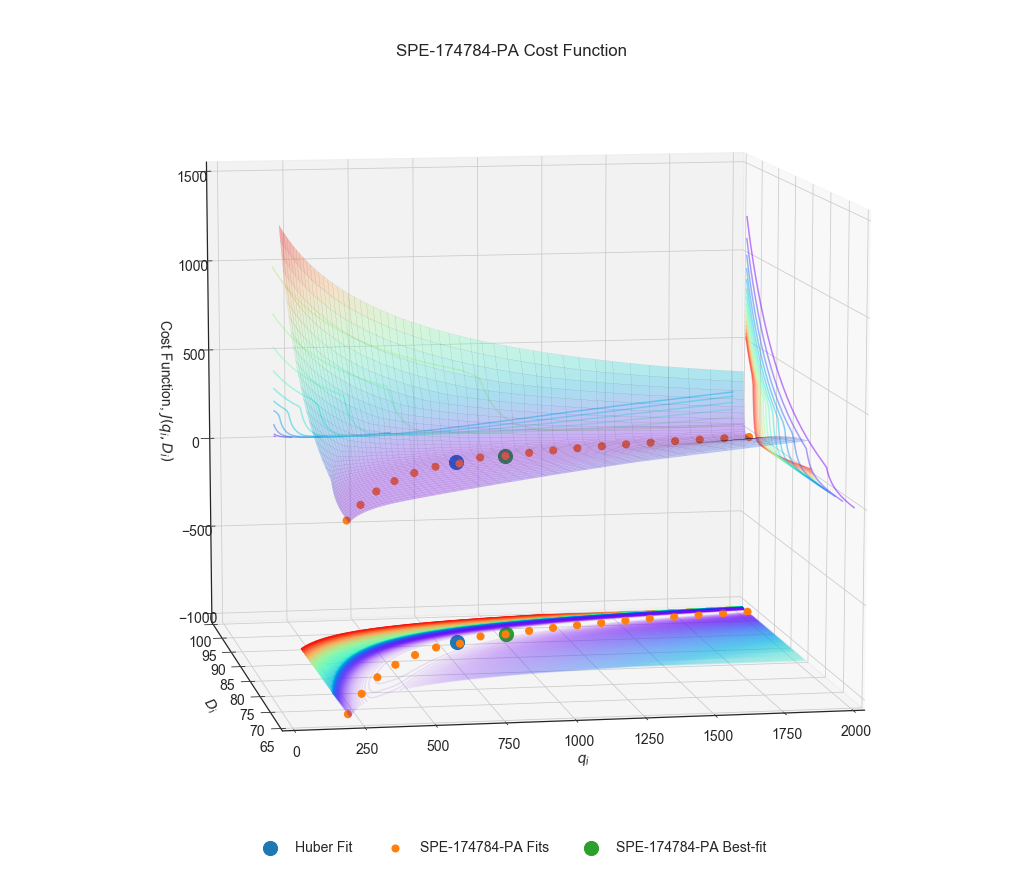

In [59]:
mpl.rcParams['font.size'] = 14

def cost_3D_R(elev, azim, xoff, yoff, zoff=-1000):
    fig = plt.figure(figsize=(14,12))
    ax = plt3d.Axes3D(fig)

    # Plot the Cost Function
    ax.plot_surface(qmesh, Dmesh_R, zmesh_R, cmap='rainbow', alpha=.3, lw=.1, edgecolor='k', antialiased=True)
    ax.scatter(sec_H[0], sec_H[1], z_H, s=200, alpha=1, label='Huber Fit')
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], z_R[:-1], c=colors[1], s=50, alpha=1, label='SPE-174784-PA Fits')
    ax.scatter(sec_R[-1,0], sec_R[-1,1], z_R[-1], c=colors[2], s=200, alpha=1, label='SPE-174784-PA Best-fit')

    # Add counter lines to the axes planes
    ax.contour(qmesh, Dmesh_R, zmesh_R, zdir='z', cmap='rainbow', alpha=.1,
               levels=np.linspace(0,500,1000), offset=zoff)
    ax.contour(qmesh, Dmesh_R, zmesh_R, zdir='x', cmap='rainbow', alpha=.5, levels=np.linspace(200,1000,15), offset=xoff)
    ax.contour(qmesh, Dmesh_R, zmesh_R, zdir='y', cmap='rainbow', alpha=.5, levels=np.linspace(65,110,15), offset=yoff)
    ax.scatter(sec_H[0], sec_H[1], zoff, c=colors[0], zdir='z', s=200, alpha=1)
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zoff, c=colors[1], s=50, alpha=1)
    ax.scatter(sec_R[-1,0], sec_R[-1,1], zoff, c=colors[2], s=200, alpha=1)

    ax.set(xlim=(0,2000), ylim=(65,100), zlim=(zoff, 1500))
    ax.set_title(label='SPE-174784-PA Cost Function', pad=20)
    ax.set_xlabel(r'$q_i$', labelpad=10)
    ax.set_ylabel(r'$D_i$', labelpad=10)
    ax.set_zlabel(r'Cost Function, $J(q_i, D_i)$', labelpad=15)
    ax.view_init(elev=elev, azim=azim)
    plt.legend(ncol=3, bbox_to_anchor=(.5, .05), loc=9)
    plt.show()
    
cost_3D_R(20, 20, 0, 65)
cost_3D_R(10, 260, 2000, 100)

Once again, we get a very similar valley of minimums. However, we see that the SPE-174784-PA cost tends to penalize an under-forecast more than an over-forecast when compared with the Huber cost.

In [61]:
def p_g(parms, time, rate, min_eps):
    #This function is optimized to avoid repeat operations
    qi = parms[0]; Di = parms[1]; b = parms[2]
    if b < 1e-4:
        b = 1e-4
    n = len(time)
    
    Dibt_1          = Di * b * time + 1
    Dibt_1_b        = Dibt_1 ** (- 1 / b)
    qt              = qi * Dibt_1_b
    residual        = np.log(rate) - np.log(qt)
    sum_residual    = np.sum(residual)
    mean_residual   = np.mean(residual)
    std_residual    = np.std(residual)
    sign_res        = np.sign(residual)

    partial_eps1    = 2 * (np.mean(np.abs(residual)) - min_eps[0]) / .1**2
    partial_eps1_qi = np.mean(-1/qi * sign_res)
    partial_eps1_Di = np.mean(time / Dibt_1 * sign_res)
    partial_eps1_b  = np.mean(Di * time / (b * Dibt_1) - 1 / b**2 * np.log(Dibt_1) * sign_res)
    gradient_eps1   = partial_eps1 * (partial_eps1_qi + partial_eps1_Di + partial_eps1_b)

    partial_eps2    = 2 * (std_residual - min_eps[1]) / .01**2 / (n * std_residual)
    partial_eps2_qi = 0 
    partial_eps2_Di = np.sum( (time/Dibt_1 - np.mean(time/Dibt_1)) * (residual - mean_residual) )
    partial_eps2_b  = np.sum( (Di * time / (b * Dibt_1) - 1 / b**2 * np.log(Dibt_1)) * (residual - mean_residual) )
    gradient_eps2   = partial_eps2 * (partial_eps2_qi + partial_eps2_Di + partial_eps2_b)
    
    return gradient_eps1 + gradient_eps2

In [62]:
zdmesh_R = np.array([p_g(parms, fit_time2, fit_rate2, min_eps) for parms in Huber_opt_R])
zdmesh_R = zdmesh_R.reshape(qmesh.shape[0], -1)

In [63]:
zd_H_R = np.array([p_g(Huber_dca_l.x, fit_time2, fit_rate2, min_eps)])
zd_R_R = np.array([p_g(parms.x, fit_time2, fit_rate2, min_eps) for parms in p_dca])

*To compute numerically:*
```
zdmesh_R = np.gradient(zmesh_R, qmesh0, axis=1)
zdmesh_R = zdmesh_R - np.gradient(zmesh_H, Dmesh_nom0, axis=0)

for i, x in enumerate(qmesh0):
    if sec_H[0] < x:
        z_H_c = i
        break
for j, y in enumerate(Dmesh_nom0):
    if sec_H[1] < y:
        z_H_r = j
        break
zd_H = np.array([zdmesh_R[z_H_r, z_H_c]]).ravel()
    
zd_R = []
for fit in p_dca:
    for i, x in enumerate(qmesh0):
        if fit.x[0] < x:
            z_H_c = i
            break
    for j, y in enumerate(Dmesh_nom0):
        if fit.x[1] < y:
            z_H_r = j
            break
    zd_R.append(zdmesh_R[z_H_r, z_H_c])
zd_R = np.array([zd_R]).ravel()
```

In [64]:
zdmesh_R[zdmesh_R<-25000]=-25000
zdmesh_R[zdmesh_R>25000]=25000

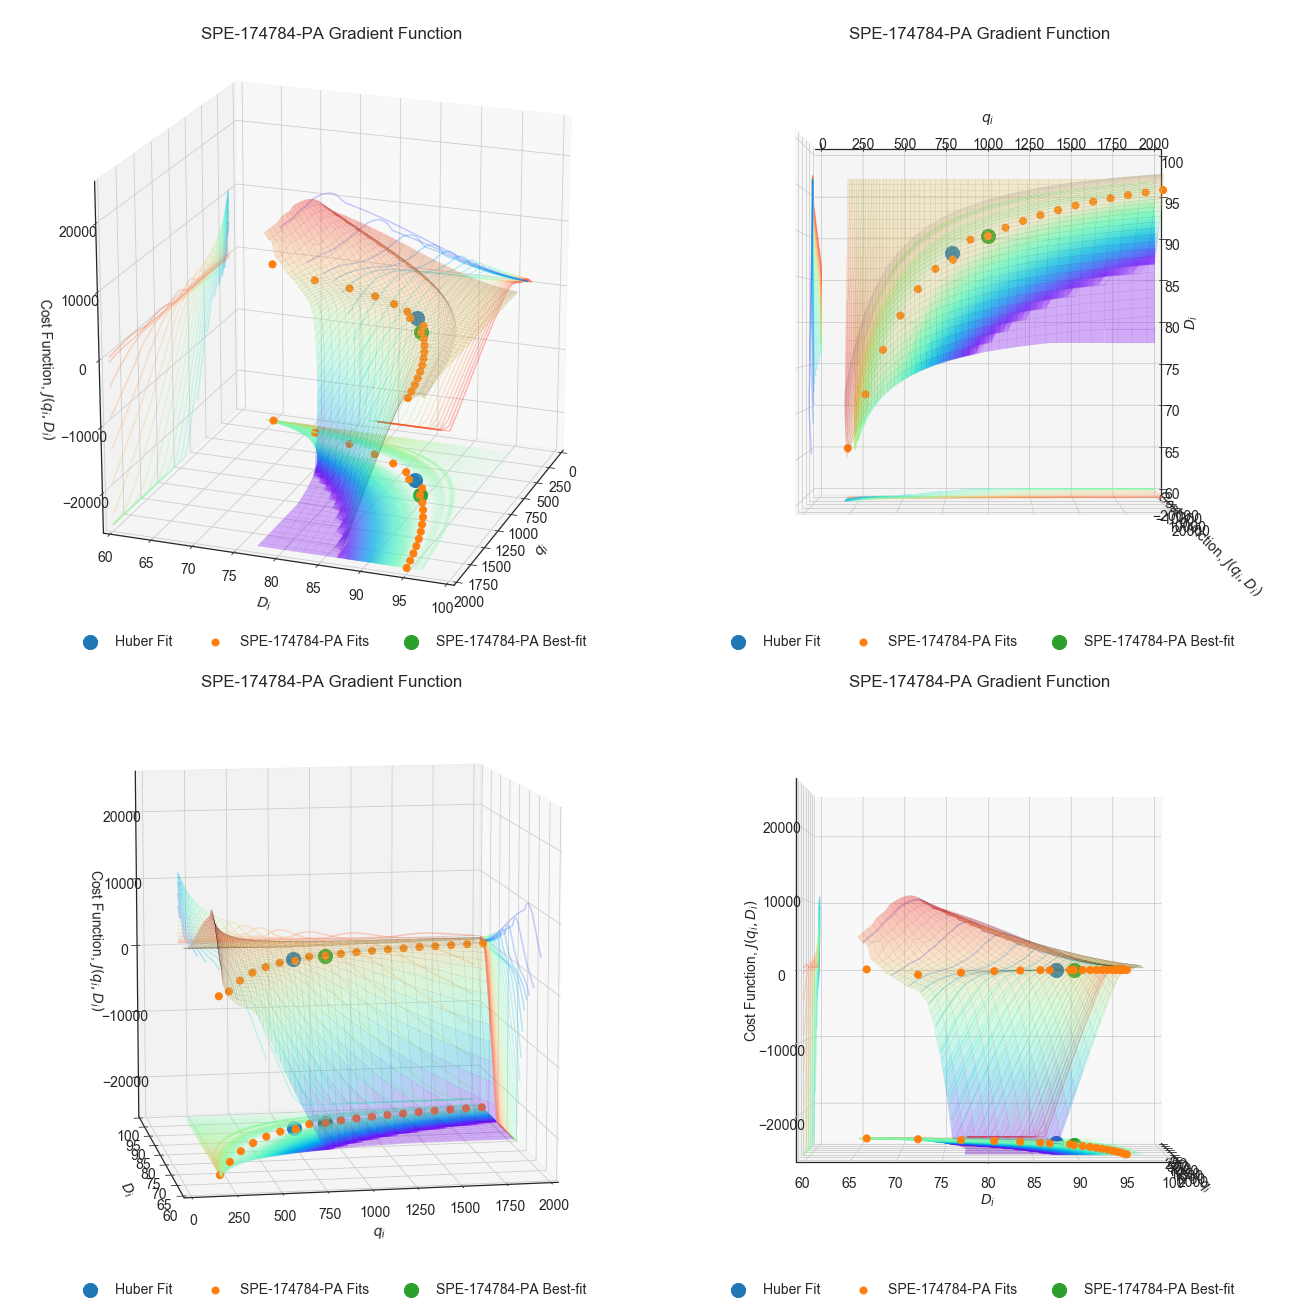

In [65]:
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(18,18))

def do_subplot(plot_num, elev, azim, zoff, xoff, yoff=100):
    zmax = 25000
    ax = fig.add_subplot('22' + str(plot_num), projection='3d')
    # Plot the Cost Function
    ax.plot_surface(qmesh, Dmesh_R, zdmesh_R, cmap='rainbow', alpha=.3, lw=.1, edgecolor='k', antialiased=True)
#     ax.plot_surface(qmesh, Dmesh_sec, np.zeros_like(zdmesh_R), color=colors[0], alpha=.1, antialiased=True)
    ax.scatter(sec_H[0], sec_H[1], zd_H_R, s=200, c=colors[0], alpha=1., label='Huber Fit')
    ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zd_R_R[:-1], c=colors[1], s=50, alpha=1, label='SPE-174784-PA Fits')
    ax.scatter(sec_R[-1,0], sec_R[-1,1], zd_R_R[-1], c=colors[2], s=200, alpha=1, label='SPE-174784-PA Best-fit')
#     ax.plot(sec_R[:,0], sec_R[:,1], zd_R, c='k', alpha=1.)
    # Add counter lines to the axes planes
    ax.contour(qmesh, Dmesh_R, zdmesh_R, zdir='z', cmap='rainbow', alpha=.1, levels=np.linspace(zoff,zmax,1000), offset=zoff)
    ax.contour(qmesh, Dmesh_R, zdmesh_R, zdir='x', cmap='rainbow', alpha=.3, levels=np.linspace(0,2000,30), offset=xoff)
    ax.contour(qmesh, Dmesh_R, zdmesh_R, zdir='y', cmap='rainbow', alpha=.3, levels=np.linspace(60,100,30), offset=yoff)
    if plot_num != 2:
        ax.scatter(sec_H[0], sec_H[1], zoff, s=200, c=colors[0], alpha=1.)
        ax.scatter(sec_R[:-1,0], sec_R[:-1,1], zoff, c=colors[1], s=50, alpha=1)
        ax.scatter(sec_R[-1,0], sec_R[-1,1], zoff, c=colors[2], s=200, alpha=1)
    
    ax.set(xlim=(0,2000), ylim=(60,100), zlim=(zoff, zmax))
    ax.set_title(label='SPE-174784-PA Gradient Function', pad=20)
    ax.set_xlabel(r'$q_i$', labelpad=10)
    ax.set_ylabel(r'$D_i$', labelpad=10)
    ax.set_zlabel(r'Cost Function, $J(q_i, D_i)$', labelpad=15)
    ax.view_init(elev=elev, azim=azim)
    plt.legend(ncol=3, bbox_to_anchor=(.5, .05), loc=9)

zmin = -25000
do_subplot(1, 20, 20, zmin, 0, 60)
do_subplot(2, 90, -90, zmin, 0, 60)
do_subplot(3, 10, 260, zmin, 2000)
do_subplot(4, 0, -0, zmin, 0, 60)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

The fits follow the gradient as it wraps around on values of zero. The gradient is not nearly as steep in the direction of $q_i$ as it is in the direction of $D_i$, which causes the fits to not deviate much from the initial condition of $q_i$. In other words, there is not enough of a gradient to climb without extremely high precision... but this doesn't much matter because the cost function is not designed to find the absolute best-fit, but to simply explore the uncertainty of the solution space. We also see that an ideal solution possibly doesn't exist for low values of $q_i$ within the bounds we've set.

### Evaluation of Uncertainty
Last, let's take the best SPE-174784-PA fit of each row from our mesh, and plot the forecast against our data to see how well these forecasts perform. We expect this to yield fits that are better than our minimize function as we've done an explicit search across the solution spac using analytic solutions, as opposed to relying on numerical calculation of the gradient and which breaks down when the gradient is small in multiple dimensions.

In [66]:
zmax = np.array([np.min(z_row) for z_row in zmesh_R])
zd_idx_c = np.unique([np.argmin(z_row) for z_row in zmesh_R])
zd_idx_r = np.array([np.argmin(z_col) for z_col in zmesh_R[:, zd_idx_c].T])
qmax = qmesh[zd_idx_r, zd_idx_c]
Dmax = Dmesh_nom[zd_idx_r, zd_idx_c]
bmax = bmesh_R[zd_idx_r, zd_idx_c]
parms_max = [[q_row, D_row, b_row] for q_row, D_row, b_row in zip(qmax, Dmax, bmax)]
y_p_max = np.array([forecast(forecast_time, fit) for fit in parms_max])
total_max = len(y_p_max)

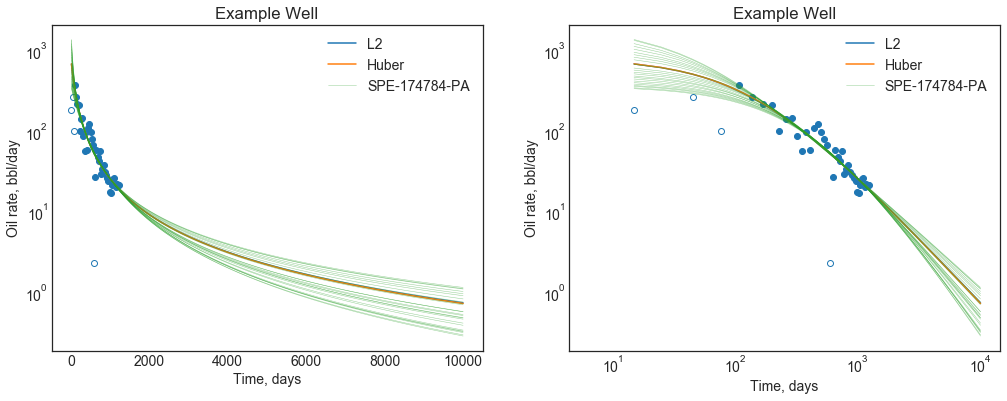

In [67]:
fig = plt.figure(figsize=(17,6))

ax1 = fig.add_subplot(121)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
plt.semilogy(forecast_time, y_L2_dca_l, label='L2')
plt.semilogy(forecast_time, y_Huber_dca_l, label='Huber')
plt.semilogy(forecast_time, y_p_max[0], color=colors[2], alpha=.5, lw=.5, label='SPE-174784-PA')
plt.semilogy(forecast_time, y_p_max[1:total_max].T, color=colors[2], alpha=.5, lw=.5)
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

ax2 = fig.add_subplot(122)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
plt.loglog(forecast_time, y_L2_dca_l, label='L2')
plt.loglog(forecast_time, y_Huber_dca_l, label='Huber')
plt.loglog(forecast_time, y_p_max[0], color=colors[2], alpha=.5, lw=.5, label='SPE-174784-PA')
plt.loglog(forecast_time, y_p_max[1:total_max].T, color=colors[2], alpha=.5, lw=.5)
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

plt.show()

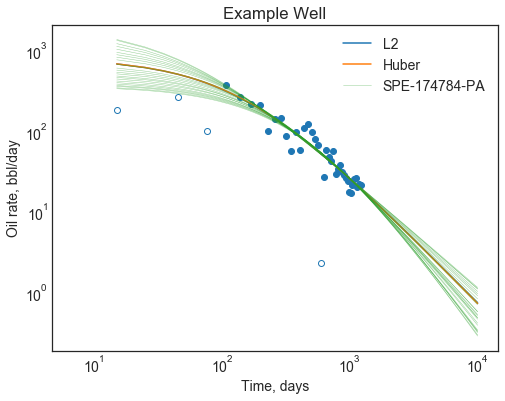

In [68]:
fig = plt.figure(figsize=(8,6))


ax2 = fig.add_subplot(111)
plt.scatter(fit_time2, fit_rate2)
plt.scatter(filtered_time2, filtered_rate2, facecolor='white', edgecolor=colors[0])
plt.loglog(forecast_time, y_L2_dca_l, label='L2')
plt.loglog(forecast_time, y_Huber_dca_l, label='Huber')
plt.loglog(forecast_time, y_p_max[0], color=colors[2], alpha=.5, lw=.5, label='SPE-174784-PA')
plt.loglog(forecast_time, y_p_max[1:total_max].T, color=colors[2], alpha=.5, lw=.5)
plt.xlabel('Time, days')
plt.ylabel('Oil rate, bbl/day')
plt.title('Example Well')
plt.legend()

plt.show()

And as before, we see that these are nearly all the same where they cover the data! The lower $q_i$ forecasts do not fit the first few data points well, which we also see in our surfaces.

We've performed a systematic sweep over what is a reasonably large solution space, and hopefully it is obvious that this workflow is highly inefficient... to build a grid/cube/hypercube of every possible parameter combination and optimize over that grid/cube/hypercube is not feasible. For this type of problem, where we ***know*** the solution is non-unique, we can trade off an exhaustive search that gets us an *exact* answer for a random search that gets us a *reasonably close* answer. The evaluation of the non-uniqueness, done efficiently, is preferred over the \[false\] precision.

This leads on to stochastic algorithms such as Monte Carlo simulation, and probabilistic acceptance/rejection techniques such as simple error tolerance, Metropolis algorithm, and more recent techniques that use automatic differentiation frameworks such as Theano, TensorFlow, and PyTorch to obtain gradient information and intelligently step model parameters.

More to discuss for another time!

## APPENDIX: Gradient Derivation

For completeness, we derive the gradient function for the SPE-174784-PA cost function. The cost function is:

$$
J_{p}= \left( \frac{\text{mean}( \lvert e \rvert ) - \epsilon_{min}}{\sigma_\epsilon} \right)^2 +
    \left( \frac{ \text{std.dev} ( e ) - \varepsilon_{min}}{\sigma_\varepsilon} \right)^2
$$

where $e = \ln{q} - \ln{\hat{q}}$, $\epsilon_{min} = 0.1$ and $\varepsilon_{min} = 0.01$. Written in terms of the regularization on the standard deviation of residuals:

$$
J_{p}= \left( \frac{\text{mean}( \lvert e \rvert ) - \epsilon_{min}}{\sigma_\epsilon} \right)^2 +
    \lambda_\varepsilon \left( \text{std.dev} ( e ) - \varepsilon_{min} \right)^2 \\\\
$$

Expanded out, this is:

$$
J_{p}= \left( \frac{\frac{1}{n} \sum\limits_{i=1}^n \lvert \ln{q} - \ln{\hat{q}} \rvert - \epsilon_{min}}{\sigma_\epsilon} \right)^2 +
    \left( \frac{ \sqrt{\frac{1}{n}\sum\limits_{i=1}^n \left(\ln{q} - \ln{\hat{q}} - \frac{1}{n}\sum\limits_{i=1}^n\ \left( \ln{q} - \ln{\hat{q}} \right) \right)^2} - \varepsilon_{min}}{\sigma_\varepsilon} \right)^2
$$

Looking at the cost function, we can see that it has an L1 penalty on the residuals, with an L2 penalty to the best-fit model, an a regularization on the standard deviation as compared with the best-fit model. Variance, and therefore standard deviation, are orthogonal to the mean of the residuals, so the bias of the model (in terms of production forecast, the initial rate) has no impact on the variance. (This is important as it should indicate that the gradient of the regularization with respect to initial rate is zero! We'll verify below.) The regularization actually imposes a penalty that *reduces* the sensitivity of the cost function to noisy data and outliers. As we saw, the result of the cost function is a surface that has a 2-D area of minimum cost as opposed to a 0-D point as in the Huber or L2 cost functions.

This is not an easy derivative to compute, but once we break it down into pieces it is not so bad!

First, set up some symbols:

In [69]:
e_min = sym.Symbol('e_{min}', real=True)
eps1 = sym.Symbol(r'\epsilon', real=True)
eps2 = sym.Symbol(r'\varepsilon', real=True)

Let's define our first term, the L2 difference of L1 from best-fit.

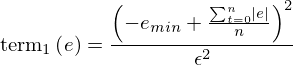

In [70]:
term1 = sym.Symbol(r'\text{term_1}', real=True)
term1_sym = ((1/n * sym.Sum(sym.Abs(e), (t,0,n))) - e_min)**2/eps1**2
sym.Eq(sym.Function('term1')(e), term1_sym)

And our second term, the regularizaton on standard deviation from best-fit. We'll do this in two parts to simplify it.

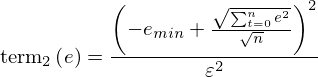

In [71]:
term2 = sym.Symbol(r'\text{term_2}', real=True)
term2_sym = ((sym.sqrt(1/n * sym.Sum((e)**2, (t,0,n)))) - e_min)**2/eps2**2
sym.Eq(sym.Function('term2')(e),term2_sym)

Sympy wants to simplify our equations, which is not ideal, but they are still recognizable to us. Let's take the derivative of the first term, which gives us the first term in application of the chain rule:

$$
f'(x) = f'\big(g(x)\big) \; g'(x)
$$

In this case, we're going to get multiple applications of the chain rule. This just looks something like:

$$
f'(x) = f'\Big(g\big(h(x)\big)\Big) \; g'\big(h(x)\big) \; h'(x)
$$

Let's begin!

In [72]:
h = sym.Symbol('h', real=True)
hx = sym.Symbol('h\'', real=True)
hxq = sym.Symbol('h\'_{q_i}', real=True)
hxD = sym.Symbol('h\'_{D_i}', real=True)
hxb = sym.Symbol('h\'_b', real=True)

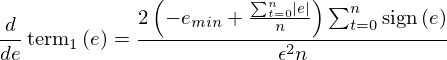

In [73]:
sym.Eq(sym.diff(sym.Function('term1')(e), e),sym.diff(term1_sym, e))

This isn't totally obvious, but we know that the derivative of the parenthetical term is just $(x^2)' = 2x \; x'$, and we can see this structure in the output. Basically, we have:

$$
f'\Big(g\big(h(x)\big)\Big) = \frac{2}{\epsilon^2} \left( \frac{1}{n}\sum\limits_{i=1}^n \lvert e \rvert - e_{min} \right) \\[1.5em]
g'\big(h(x)\big) = \frac{1}{n}\sum\limits_{i=1}^n sign(e) \\[1.5em]
h'(x) = e'
$$

So, now we can evaluate the derivatives of our residuals with respect to each parameter!

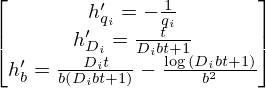

In [74]:
sym.Matrix([sym.Eq(hxq,sym.diff(res_sym,qi)),
            sym.Eq(hxD,sym.diff(res_sym,Di)),
            sym.Eq(hxb,sym.diff(res_sym,b))])

Let's check against the symbolic derivative for $q_i$.

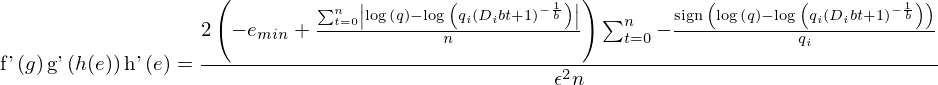

In [75]:
fp = sym.Function('f\'')(g)
g = sym.Function('g')(h)
h = sym.Function('h')(e)

gp = sym.Function('g\'')(h)
hp = sym.Function('h\'')(e)

display(sym.Eq(fp*gp*hp,sym.diff(term1_sym.subs(e, res_sym), qi)))

Looks good!

##### Second Term
From the second term, we have:

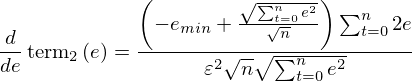

In [76]:
sym.Eq(sym.diff(sym.Function('term2')(e), e),sym.diff(term2_sym, e))

Where $e$ is:

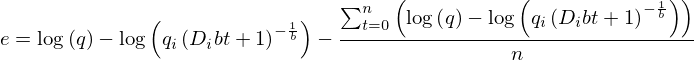

In [77]:
mean_res = 1/n * sym.Sum(res_sym, (t,0,n))
sym.Eq(e, res_sym - mean_res)

And the variance of the residuals would be given by, as repeated from above:

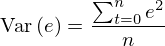

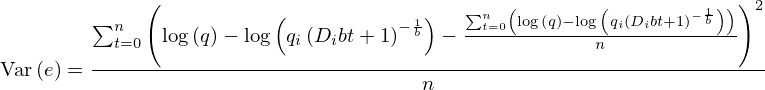

In [78]:
Var = sym.Symbol('Var')
display(sym.Eq(sym.Function('Var')(e), (1/n * sym.Sum((e)**2, (t,0,n)))))
display(sym.Eq(sym.Function('Var')(e), (1/n * sym.Sum((e)**2, (t,0,n))).subs(e, res_sym - mean_res)))

This one is a bit more confusing, but let's break it down. If we have:

$$
z = \left( \sqrt{e} - e_{min} \right) ^2
$$

Then:

$$
z' = f'\big(g(h)\big) \times g'(h) = 2 \left( \sqrt{e} - e_{min} \right) \times \frac{d}{de}\sqrt{e}
$$

And:

$$
g'(h)\times h' = \frac{1}{2\sqrt{e}} \times \frac{d}{de} e = \frac{1}{2\sqrt{e}} e'
$$

Giving us:

$$
f'\bigg(g\Big(h\big(i(x)\big)\Big)\bigg) = 2\left(\sqrt{e}- e_{min}\right) \\[1.5em]
g'\Big(h\big(i(x)\big)\Big) = \frac{1}{2\sqrt{e}} \\[1.5em]
h'\big(i(x)\big) = e'
$$

We'll also have, in this case:

$$
i'(x) = e''
$$


What is $h'\big(i(x)\big) \, i'(x)$? Let's take a look:

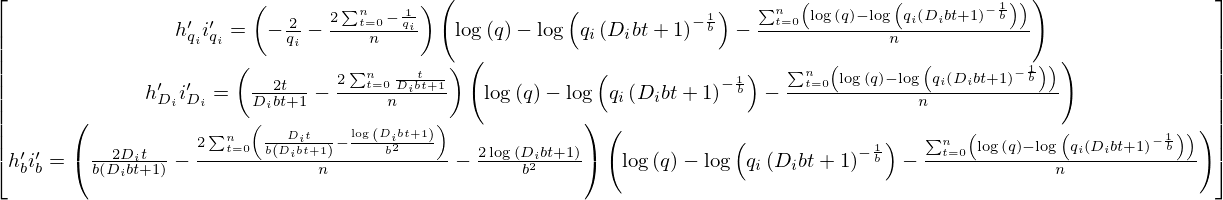

In [79]:
ixq = sym.Symbol('i\'_{q_i}', real=True)
ixD = sym.Symbol('i\'_{D_i}', real=True)
ixb = sym.Symbol('i\'_b', real=True)
sym.Matrix([sym.Eq(hxq*ixq,sym.diff((res_sym-mean_res)**2,qi)),
            sym.Eq(hxD*ixD,sym.diff((res_sym-mean_res)**2,Di)),
            sym.Eq(hxb*ixb,sym.diff((res_sym-mean_res)**2,b))])

And $i'(x) = e''$:

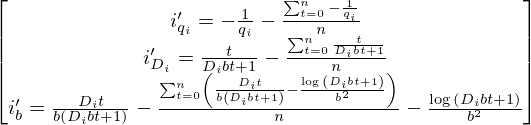

In [80]:
sym.Matrix([sym.Eq(ixq,sym.diff(res_sym-mean_res,qi)),
            sym.Eq(ixD,sym.diff(res_sym-mean_res,Di)),
            sym.Eq(ixb,sym.diff(res_sym-mean_res,b))])

Let's take a look at the full symbolic derivative with our residuals:

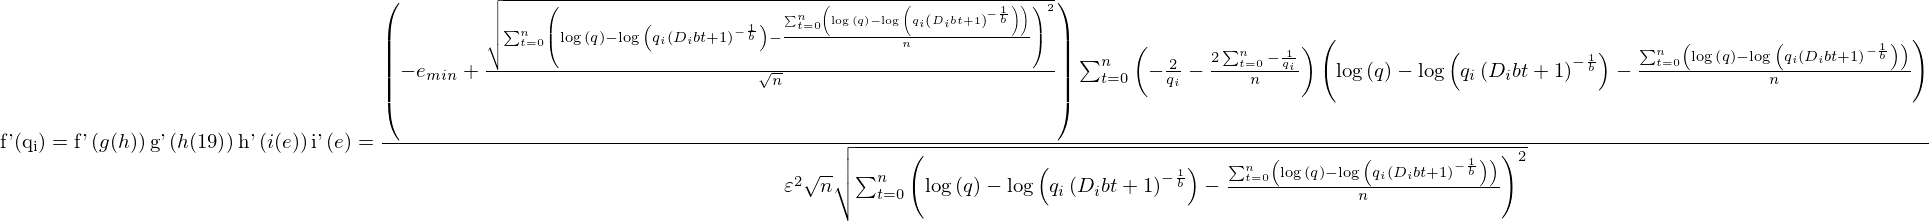

In [81]:
fp = sym.Function('f\'(q_{i})=f\'')(g)
g = sym.Function('g')(h)
h = sym.Function('h')(i)
i = sym.Function('i')(e)

gp = sym.Function('g\'')(h)
hp = sym.Function('h\'')(i)
ip = sym.Function('i\'')(e)

sym.Eq(
       fp*gp*hp*ip,
       sym.diff(((sym.sqrt(1/n * sym.Sum((res_sym - mean_res)**2, (t,0,n)))) - e_min)**2/eps2**2,qi))

Breaking this down row by row we have:

1. $f'\bigg(g\Big(h\big(i\big)\Big)\bigg)$
2. $i_{q_i}' \; h'\big(i\big)$
3. $g'\Big(h\big(i\big)\Big)$


Note, however, that $i'_{q_i}$ is zero! When we inspect $i'$ above we see that this is ***not*** true for $i'_{D_i}$ and $i'_{b}$, proving as stated at the start that the regularization on standard deviation is not a function of the model bias (intercept, or initial rate); rather, it generalizes the cost function to operate on production data with any amount of noise.

The completed function is repeated below.

```
def p_g(parms, time, rate, min_eps):
    #This function is optimized to avoid repeat operations
    qi = parms[0]; Di = parms[1]; b = parms[2]
    if b < 1e-4:
        b = 1e-4
    n = len(time)
    Dibt_1          = Di * b * time + 1
    Dibt_1_b        = Dibt_1 ** (- 1 / b)
    qt              = qi * Dibt_1_b
    residual        = np.log(rate) - np.log(qt)
    sum_residual    = np.sum(residual)
    mean_residual   = np.mean(residual)
    std_residual    = np.std(residual)
    sign_res        = np.sign(residual)

    partial_eps1    = 2 * (np.mean(np.abs(residual)) - min_eps[0]) / .1**2
    partial_eps1_qi = np.mean(-1/qi * sign_res)
    partial_eps1_Di = np.mean(time / Dibt_1 * sign_res)
    partial_eps1_b  = np.mean(Di * time / (b * Dibt_1) - 1 / b**2 * np.log(Dibt_1) * sign_res)
    gradient_eps1   = partial_eps1 * (partial_eps1_qi + partial_eps1_Di + partial_eps1_b)

    partial_eps2    = 2 * (std_residual - min_eps[1]) / .01**2 / (n * std_residual)
    partial_eps2_qi = 0 
    partial_eps2_Di = np.sum( (time/Dibt_1 - np.mean(time/Dibt_1)) * (residual - mean_residual) )
    partial_eps2_b  = np.sum( (Di * time / (b * Dibt_1) - 1 / b**2 * np.log(Dibt_1)) * (residual - mean_residual) )
    gradient_eps2   = partial_eps2 * (partial_eps2_qi + partial_eps2_Di + partial_eps2_b)
    
    return gradient_eps1 + gradient_eps2
```